In [1]:
#pip install ee

In [2]:
#pip install geemap

# Import Libraries

In [3]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [4]:
# Read the lake IDs and coordinates from Excel data
data_path = 'ALTM-50-stations.xlsx'
df_lake_info = pd.read_excel(data_path, sheet_name='updated station coordinates', usecols=['SITE_ID', 'SITE_NAME','LATDD_CENT', 'LONDD_CENT'])

# Updated target_lake_ids list with string representation
target_lake_ids = [
    '020058', '020059', '020138', '020188', '020197',
    '030171', '030172', '040186', '040210', '040576',
    '040704', '040707', '040826', '040850', '040852',
    '040874', '040887', '041007', '050215', '050649',
    '050669', '050706', '050707', '060182', '060315A',
    '070859', '1A1-017', '1A1-029', '1A1-052', '1A1-059',
    '1A1-071', '1A1-087', '1A1-089', '1A1-102', '1A1-103',
    '1A1-105', '1A1-106', '1A1-107', '1A1-109', '1A1-110',
    '1A1-111', '1A1-112', '1A2-028', '1A2-066', '1A2-076',
    '1A2-077', '1A2-078', '1A3-001', '1A3-048', '1A3-065'
]




In [5]:
# Function to create a five-sided polygon around the latitude and longitude
def create_lake_polygon(lat, lon):
    # Assuming each pixel is approximately 20 meters in size
    buffer_distance_meters = 3 * 20  
    
    # Convert buffer distance from meters to degrees (approximate conversion)
    buffer_distance_degrees = buffer_distance_meters / 111320.0
    
    # Define the coordinates of the five vertices of the polygon
    coordinates = [
        [lon, lat + buffer_distance_degrees],
        [lon + buffer_distance_degrees, lat + buffer_distance_degrees/2],
        [lon + buffer_distance_degrees/2, lat - buffer_distance_degrees/2],
        [lon - buffer_distance_degrees/2, lat - buffer_distance_degrees/2],
        [lon - buffer_distance_degrees, lat + buffer_distance_degrees/2]
    ]
    
    # Create the polygon geometry
    polygon = ee.Geometry.Polygon(coordinates)
    
    return polygon

In [6]:
sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

# Masking Clouds

In [7]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create the cloud mask
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the cloud mask to the image
    maskedImage = image.updateMask(cloudMask)

    return maskedImage

In [8]:
# Function to calculate CDOM from Sentinel-2 images
def cdom(img, lake):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1': img.select('Aerosols'),
        'b2': img.select('Blue'),
        'b3': img.select('Green'),
        'b4': img.select('Red')
    }).rename("CO")
    
    bad2 = cdo.where(cdo.gte(0), 1).rename("bad2")
    co = cdo.multiply(bad2).rename("CO")
    mask = co.neq(0)

    return img.addBands(co).clip(lake).updateMask(mask)

In [9]:
# Load Sentinel-2 data and apply the processing steps
s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(2019, 2023, 'year')) \
    .map(maskS2clouds) \
    .select(sentinel2_bands, STD_NAMES)\

# Function to process the data for a specific lake
def process_lake(lake_id, lat, lon):
    # Create a polygon around the lake using the latitude and longitude
    lake_polygon = create_lake_polygon(lat, lon)

    # Load the lake polygon to the map
    Map.addLayer(ee.Feature(lake_polygon), {'color': 'blue'}, f"Lake {lake_id}")

    # Load the lake-specific feature collection
    lake_collection = ee.FeatureCollection('projects/ee-touhedakhanom14/assets/lake_polygons') \
        .filter(ee.Filter.eq('SITE_ID', lake_id))

    # Apply the processing steps for the lake
    s2_lake = s2.filterBounds(lake_polygon) \
               .map(lambda img: cdom(img, lake_polygon)) \
               .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
    
    # Display the first image in the collection
    Map.addLayer(s2_lake.first(), {}, f"Lake {lake_id} Image")

    return s2_lake

In [10]:
# Get the list of lake IDs
lake_ids = df_lake_info['SITE_ID'].tolist()

In [11]:
# Lake/Pond Names with Assigned Lake ID:
# SITE_ID
# - 020058: Little Hope Pond           - 020059: Big Hope Pond
# - 020138: East Copperas Pond         - 020188: Sunday Pond
# - 020197: Sochia Pond                - 030171: Grass Pond (3)
# - 030172: Little Clear Pond          - 040186: Loon Hollow Pond
# - 040210: Willys Lake                - 040576: Woods Lake
# - 040704: Middle Settlement Lake     - 040707: Middle Branch Lake
# - 040826: Limekiln Lake              - 040850: Squaw Lake
# - 040852: Indian Lake                - 040874: Brook Trout Lake
# - 040887: Lost Pond                  - 041007: North Lake
# - 050215: Willis Lake                - 050649: Long Pond
# - 050669: Carry Pond                 - 050706: Lake Colden
# - 050707: Avalanche Lake             - 060182: Little Simon Pond
# - 060315A: Raquette Lake Reservoir   - 070859: G Lake
# - 1A1-017: Constable Pond            - 1A1-029: Middle Pond
# - 1A1-052: Arbutus Pond              - 1A1-059: Sagamore Lake
# - 1A1-071: Black Pond                - 1A1-087: Windfall Pond
# - 1A1-089: Queer Lake                - 1A1-102: Heart Lake
# - 1A1-103: Big Moose Lake            - 1A1-105: Cascade Lake
# - 1A1-106: Dart Lake                 - 1A1-107: Little Echo Pond
# - 1A1-109: Moss Lake                 - 1A1-110: Lake Rondaxe
# - 1A1-111: Squash Pond               - 1A1-112: West Pond
# - 1A2-028: Owen Pond                 - 1A2-066: Jockeybush Lake
# - 1A2-076: Barnes Lake               - 1A2-077: Clear Pond
# - 1A2-078: Otter Lake                - 1A3-001: Nate Pond
# - 1A3-048: Grass Pond                - 1A3-065: South Lake (East Branch)

In [12]:
# Create a geemap Map
Map = geemap.Map()

# Get the list of lake IDs
lake_ids = df_lake_info['SITE_ID'].tolist()

# Prompt the user to enter the ID of the lake they want to analyze
selected_lake_id = input("Enter the ID of the lake you want to analyze: ")

# Check if the selected lake ID is in the list of lake IDs
if selected_lake_id not in lake_ids and int(selected_lake_id) not in lake_ids:
    print("Lake ID not found. Please select a valid lake ID.")
else:
    # Get the information for the selected lake
    lake_info = df_lake_info[df_lake_info['SITE_ID'] == selected_lake_id].iloc[0]
    lat = lake_info['LATDD_CENT']
    lon = lake_info['LONDD_CENT']

    # Create a polygon around the selected lake using the latitude and longitude
    lake_polygon = create_lake_polygon(lat, lon)

    # Call the process_lake function to process the data for the selected lake
    s2_lake = process_lake(selected_lake_id, lat, lon)

    Map.centerObject(lake_polygon, 14)
    # Display the map with the lake ID as the image name
    #Map.addLayer(s2.first(), {}, f"Lake {selected_lake_id} Image")

# Display the map
#Map.addLayerControl()
#1A1-103
Map

Enter the ID of the lake you want to analyze: 1A1-103


Map(center=[43.832322289134716, -74.84646000014948], controls=(WidgetControl(options=['position', 'transparent…

In [13]:
#Map.user_roi.getInfo()

In [14]:
#Map.addLayer(s2.first(), {}, lake_name + " Image")

In [15]:
# Convert the image collection to a list and get the last image
s2_list = s2.toList(s2.size())
last_image = ee.Image(s2_list.get(-1))
#geemap.image_props(last_image).getInfo()

In [16]:
#image = se.first()

In [17]:
imageFirst = s2.first()
#geemap.image_props(imageFirst).getInfo()

In [18]:
#print(s2.getInfo())

In [19]:
vis_params = {'bands': ['Red', 'Green', 'Blue'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}

In [20]:
vis_params = {'bands': ['Red', 'Green', 'Blue'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}

In [21]:
first_image = s2.first()  # Get the first image from the collection
band_names = first_image.bandNames().getInfo()
print("Band Names:", band_names)

Band Names: ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1']


In [22]:
#How many images?
#print(s2.size().getInfo())


# CDOM

In [23]:
def station_mean(img): # station_mean function with a single parameter img
    #mean of a specific band (CO) within a region 
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake_polygon, scale=20).get('CO')
    return img.set('date', img.date().format()).set('CDOM',mean)

station_reduced_imgs = s2_lake.map(station_mean)
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','CDOM']).get('list')
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])

pd.set_option('display.max_rows', None)
print(df)

                   date         CDOM
0   2019-03-27T16:01:03     7.965958
1   2019-04-16T16:01:06     7.798394
2   2019-05-16T16:01:08     4.530977
3   2019-05-26T16:01:07     6.724370
4   2019-05-31T16:01:12     7.641729
5   2019-06-15T16:01:07     6.845989
6   2019-07-10T16:01:15     6.579517
7   2019-07-30T16:01:12     4.688567
8   2019-08-04T16:01:08     5.605281
9   2019-08-09T16:01:13     7.832604
10  2019-08-14T16:01:07     8.150298
11  2019-09-13T16:01:02     7.654232
12  2019-09-18T16:01:03     2.171948
13  2019-10-08T16:01:05     7.872529
14  2019-10-13T16:01:07    16.818809
15  2019-11-17T16:01:02  7021.686998
16  2020-03-01T16:00:59     7.808064
17  2020-03-16T16:01:02     7.664862
18  2020-04-25T16:00:59     1.798636
19  2020-05-05T16:01:01     1.974622
20  2020-05-20T16:01:09     6.160147
21  2020-06-04T16:01:06     6.255144
22  2020-06-09T16:01:10     7.335447
23  2020-06-19T16:01:10     4.668343
24  2020-06-24T16:01:06     4.890724
25  2020-06-29T16:01:09     3.830189
2

In [24]:
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

date         CDOM
0   2019-03-27     7.965958
1   2019-04-16     7.798394
2   2019-05-16     4.530977
3   2019-05-26     6.724370
4   2019-05-31     7.641729
5   2019-06-15     6.845989
6   2019-07-10     6.579517
7   2019-07-30     4.688567
8   2019-08-04     5.605281
9   2019-08-09     7.832604
10  2019-08-14     8.150298
11  2019-09-13     7.654232
12  2019-09-18     2.171948
13  2019-10-08     7.872529
14  2019-10-13    16.818809
15  2019-11-17  7021.686998
16  2020-03-01     7.808064
17  2020-03-16     7.664862
18  2020-04-25     1.798636
19  2020-05-05     1.974622
20  2020-05-20     6.160147
21  2020-06-04     6.255144
22  2020-06-09     7.335447
23  2020-06-19     4.668343
24  2020-06-24     4.890724
25  2020-06-29     3.830189
26  2020-07-04     4.930246
27  2020-07-09     5.133758
28  2020-07-19     6.886747
29  2020-07-24     2.809424
30  2020-08-08     4.773800
31  2020-08-23     4.837655
32  2020-09-12     1.539742
33  2020-09-22     5.194312
34  2020-10-17     7.747284
35  2020-11-06     7.629778
36  2020-11-21     6.915488
37  2021-01-10     7.802773
38  2021-01-30     7.427997
39  2021-02-04     7.854804
40  2021-03-21     7.861271
41  2021-04-05     7.653777
42  2021-04-10     1.920659
43  2021-06-24     6.493262
44  2021-09-07     0.807573
45  2021-10-12    12.273096
46  2021-11-06     5.479304
47  2021-12-21    11.409015
48  2022-01-20     7.782118
49  2022-01-30     7.924565
50  2022-02-09     7.402128
51  2022-02-24     8.051188
52  2022-03-16     7.221290
53  2022-03-21     7.809350
54  2022-04-15     7.314549
55  2022-04-30     8.064424
56  2022-05-05     7.357703
57  2022-05-10     7.938747
58  2022-05-25     7.678908
59  2022-05-30     7.820474
60  2022-06-04     7.588125
61  2022-06-19     7.748778
62  2022-06-24     6.900600
63  2022-07-09     7.742170
64  2022-07-19     7.568957
65  2022-07-29     7.321180
66  2022-08-13     7.336495
67  2022-08-28     7.744195
68  2022-09-02     7.425154
69  2022-09-17     7.979853
70  2022-10-02     7.638340
71  2022-10-22     7.587261
72  2022-10-27     6.731542
73  2022-11-26     8.302897
74  2022-12-21     6.757018
75  2023-01-15     7.790896
76  2023-02-14     7.845704
77  2023-03-06     7.109266
78  2023-03-21     6.293493
79  2023-04-10     7.720755
80  2023-04-15     6.696248
81  2023-04-20     7.810515
82  2023-05-10     7.144039
83  2023-05-15     7.807746
84  2023-05-30     7.421480
85  2023-06-19     7.085200
86  2023-07-04     7.648272
87  2023-07-19     7.401364

In [25]:
# import pandas as pd

# # Filter out CDOM values greater than 20
# df = df[df['CDOM'] <= 20]


# df

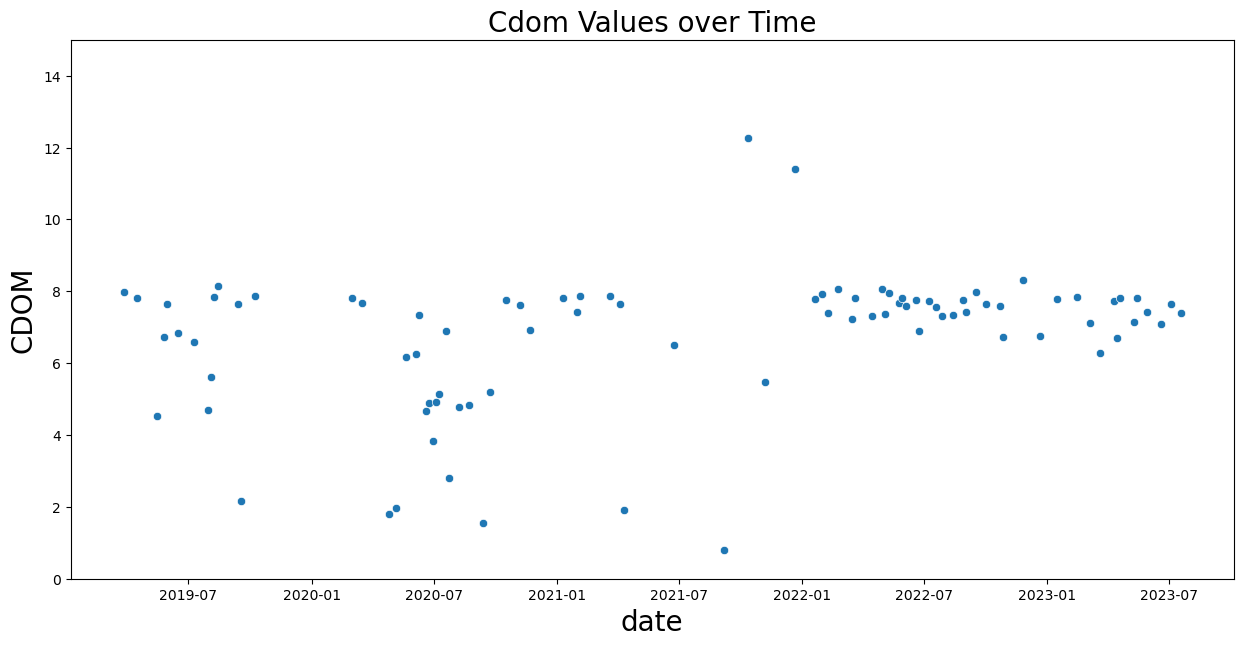

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time', fontsize=20)
ax.set_ylim(0,15)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


# Reflectance Values

In [27]:
# Function to calculate the mean of specific bands indicated by STD_NAMES for a given lake polygon
def reflectance(img, lake):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake_polygon, scale=30).select(STD_NAMES)
    return ee.Feature(None, {'date': img.date().format(), 'reflectance': reflectance_values})

# Calculate the reflectance values for all dates for the selected lake
s2_reflectance = s2_lake.map(lambda img: reflectance(img, lake_polygon))

# Convert the image collection to a list and get the data for the DataFrame
s2_list = s2_reflectance.reduceColumns(ee.Reducer.toList(2), ['date', 'reflectance']).values().get(0)
df_s2_reflectance = pd.DataFrame(s2_list.getInfo(), columns=['date', 'reflectance'])

# Convert date column to datetime and extract date only
df_s2_reflectance['date'] = pd.to_datetime(df_s2_reflectance['date']).dt.date

# Set the reflectance column values to a dictionary
df_s2_reflectance['reflectance'] = df_s2_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})
df_s2_reflectance

date                                        reflectance
0    2019-01-11                                                 {}
1    2019-02-25                                                 {}
2    2019-03-27  {'Aerosols': 8986.172413793105, 'Blue': 9068.2...
3    2019-04-16  {'Aerosols': 5313.144827586207, 'Blue': 5476.2...
4    2019-05-06                                                 {}
5    2019-05-16  {'Aerosols': 234.98620689655172, 'Blue': 169.7...
6    2019-05-26  {'Aerosols': 333.78068965517247, 'Blue': 283.6...
7    2019-05-31  {'Aerosols': 279.96551724137936, 'Blue': 382.5...
8    2019-06-15  {'Aerosols': 432.2503448275863, 'Blue': 383.21...
9    2019-07-10  {'Aerosols': 302.60482758620685, 'Blue': 313.7...
10   2019-07-15                                                 {}
11   2019-07-25                                                 {}
12   2019-07-30  {'Aerosols': 714.5420689655173, 'Blue': 618.00...
13   2019-08-04  {'Aerosols': 310.64, 'Blue': 233.0379310344828...
14   2019-08-09  {'Aerosols': 3302.988965517242, 'Blue': 2906.2...
15   2019-08-14  {'Aerosols': 361.29310344827593, 'Blue': 261.2...
16   2019-08-29                                                 {}
17   2019-09-13  {'Aerosols': 215.06137931034488, 'Blue': 160.3...
18   2019-09-18  {'Aerosols': 67.88965517241381, 'Blue': 78.081...
19   2019-10-08  {'Aerosols': 10.617241379310348, 'Blue': 40.49...
20   2019-10-13  {'Aerosols': 16.397931034482763, 'Blue': 1.655...
21   2019-11-17  {'Blue': 10.775862068965518, 'Green': 1.771034...
22   2020-02-15                                                 {}
23   2020-03-01  {'Aerosols': 9581.19379310345, 'Blue': 9576.77...
24   2020-03-16  {'Aerosols': 4394.631724137931, 'Blue': 4597.0...
25   2020-03-21                                                 {}
26   2020-04-20                                                 {}
27   2020-04-25  {'Aerosols': 87.8896551724138, 'Blue': 87.7662...
28   2020-05-05  {'Aerosols': 101.5489655172414, 'Blue': 100.75...
29   2020-05-20  {'Aerosols': 195.4744827586207, 'Blue': 167.79...
30   2020-05-25                                                 {}
31   2020-05-30                                                 {}
32   2020-06-04  {'Aerosols': 324.88413793103456, 'Blue': 342.1...
33   2020-06-09  {'Aerosols': 299.59793103448277, 'Blue': 260.1...
34   2020-06-19  {'Aerosols': 184.31241379310347, 'Blue': 120.9...
35   2020-06-24  {'Aerosols': 554.2351724137932, 'Blue': 507.02...
36   2020-06-29  {'Aerosols': 505.3462068965518, 'Blue': 379.70...
37   2020-07-04  {'Aerosols': 225.60551724137935, 'Blue': 234.4...
38   2020-07-09  {'Aerosols': 299.128275862069, 'Blue': 222.536...
39   2020-07-19  {'Aerosols': 329.1441379310345, 'Blue': 280.06...
40   2020-07-24  {'Aerosols': 133.90275862068967, 'Blue': 132.8...
41   2020-08-08  {'Aerosols': 364.15379310344827, 'Blue': 245.1...
42   2020-08-23  {'Aerosols': 221.54965517241376, 'Blue': 210.9...
43   2020-08-28                                                 {}
44   2020-09-12  {'Aerosols': 58.19172413793104, 'Blue': 70.335...
45   2020-09-22  {'Aerosols': 431.9489655172414, 'Blue': 426.58...
46   2020-10-17  {'Aerosols': 133.5448275862069, 'Blue': 85.753...
47   2020-11-06  {'Aerosols': 301.42689655172416, 'Blue': 244.1...
48   2020-11-21  {'Aerosols': 771.048275862069, 'Blue': 908.222...
49   2021-01-10  {'Aerosols': 8028.00275862069, 'Blue': 8357.82...
50   2021-01-30  {'Aerosols': 7710.200607902737, 'Blue': 8416.7...
51   2021-02-04  {'Aerosols': 9399.927586206899, 'Blue': 9410.4...
52   2021-03-21  {'Aerosols': 5112.16551724138, 'Blue': 5423.26...
53   2021-04-05  {'Aerosols': 1933.0634482758624, 'Blue': 1953....
54   2021-04-10  {'Aerosols': 67.27724137931035, 'Blue': 82.433...
55   2021-05-20                                                 {}
56   2021-05-25                                                 {}
57   2021-06-19                                                 {}
58   2021-06-24  {'Aerosols': 295.47172413793106, 'Blue': 

In [28]:
# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)



         Band   Reflectance        Date
0    Aerosols   8986.172414  2019-03-27
1        Blue   9068.270345  2019-03-27
2       Green   9085.582069  2019-03-27
3         Red   9230.423448  2019-03-27
4    RedEdge1   9371.842759  2019-03-27
5    RedEdge2   9038.766897  2019-03-27
6    RedEdge4   8777.693103  2019-03-27
7         NIR   8187.646207  2019-03-27
8       SWIR1    416.114483  2019-03-27
9    Aerosols   5313.144828  2019-04-16
10       Blue   5476.204138  2019-04-16
11      Green   5420.340690  2019-04-16
12        Red   5447.197931  2019-04-16
13   RedEdge1   5564.982069  2019-04-16
14   RedEdge2   5204.675862  2019-04-16
15   RedEdge4   4888.955172  2019-04-16
16        NIR   4556.174483  2019-04-16
17      SWIR1    206.460690  2019-04-16
18   Aerosols    234.986207  2019-05-16
19       Blue    169.724138  2019-05-16
20      Green    130.644138  2019-05-16
21        Red    106.968276  2019-05-16
22   RedEdge1    101.546897  2019-05-16
23   RedEdge2     81.591034  2019-05-16


In [29]:
#Average band reflectance values for each month
data_by_month = {}

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'reflectance_values': {band: [] for band in STD_NAMES}}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['reflectance_values'][band].append(value)

# Calculate the average reflectance values for each band within each month
average_data = {'band': [], 'average_reflectance': []}

for month, data in data_by_month.items():
    for band, reflectance_values in data['reflectance_values'].items():
        if reflectance_values:  # Check if reflectance_values is not empty
            average_value = sum(reflectance_values) / len(reflectance_values)
            average_data['band'].append(band)
            average_data['average_reflectance'].append(average_value)

# Create a dataframe from the average data
df_average_data = pd.DataFrame(average_data)

# Display the dataframex
print(df_average_data)


        band  average_reflectance
0   Aerosols             0.898617
1       Blue             0.906827
2      Green             0.908558
3        Red             0.923042
4   RedEdge1             0.937184
5   RedEdge2             0.903877
6   RedEdge4             0.877769
7        NIR             0.818765
8      SWIR1             0.041611
9   Aerosols             0.531314
10      Blue             0.547620
11     Green             0.542034
12       Red             0.544720
13  RedEdge1             0.556498
14  RedEdge2             0.520468
15  RedEdge4             0.488896
16       NIR             0.455617
17     SWIR1             0.020646
18  Aerosols             0.028291
19      Blue             0.027864
20     Green             0.026859
21       Red             0.020809
22  RedEdge1             0.023917
23  RedEdge2             0.026075
24  RedEdge4             0.023757
25       NIR             0.020759
26     SWIR1             0.011786
27  Aerosols             0.043225
28      Blue  

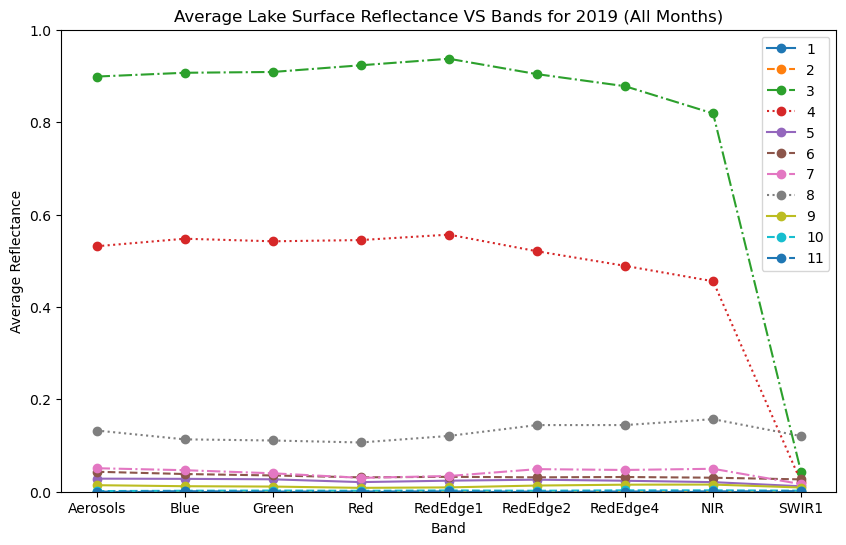

In [30]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['dates'].append(date)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in data_by_month.items():
    unique_dates = list(set(data['dates']))  # Get unique dates for the month
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    
    average_reflectance_values = []
    for band in STD_NAMES:
        reflectance_values = [data['reflectance'][i] for i in range(len(data['band'])) if data['band'][i] == band]
        
        if len(reflectance_values) > 0:
            average_reflectance = sum(reflectance_values) / len(reflectance_values)
            average_reflectance_values.append(average_reflectance)
        else:
            average_reflectance_values.append(0)
    
    plt.plot(STD_NAMES, average_reflectance_values, linestyle=line_style, marker='o', label=month)
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 1)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for 2019 (All Months)')
plt.legend()
plt.show()




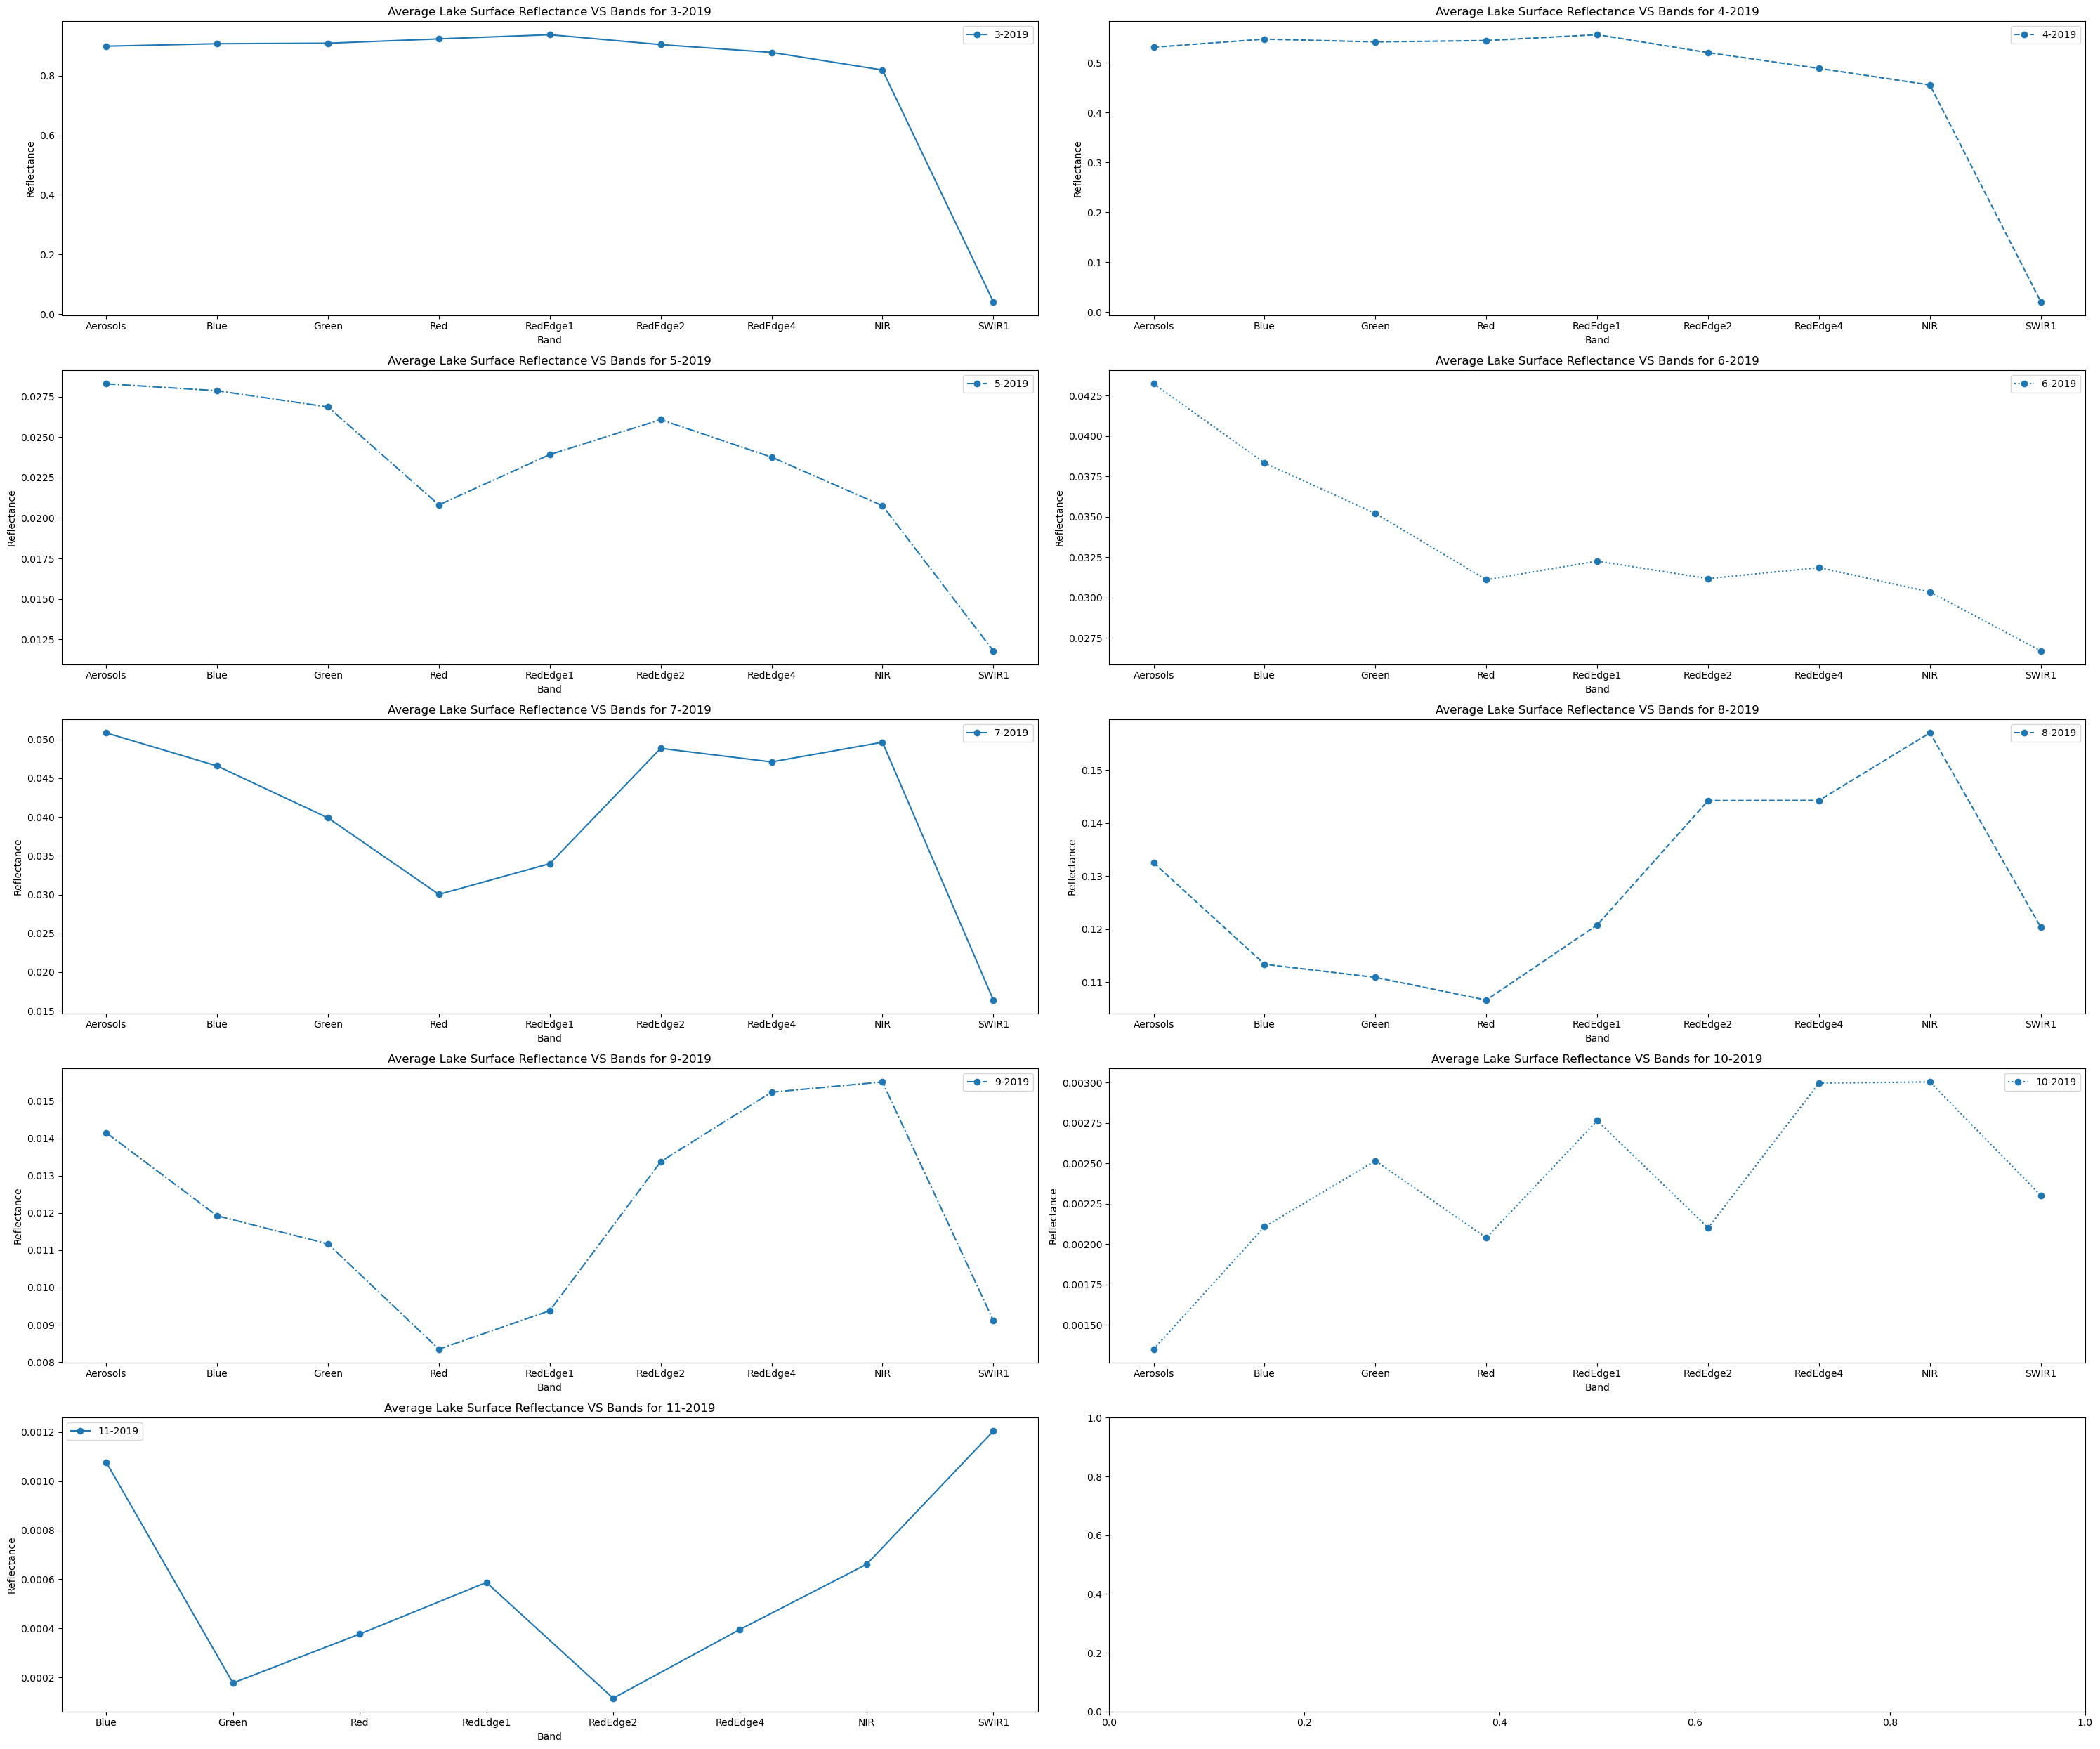

In [31]:
import numpy as np

data_by_month = {}

# Iterate over the dataframe rows
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    # Filter data for specific months
    if year == 2019 and date.month in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {band: [] for band in STD_NAMES}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month][band].append(value)
                else:
                    data_by_month[month][band].append(np.nan)

# Calculate the average reflectance values for each band within each month
averages_by_month = {
    month: {band: np.nanmean(values) for band, values in data.items()}
    for month, data in data_by_month.items()
}

# Define plot parameters
line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)

# Calculate the number of rows and columns for the subplots
num_months = len(data_by_month)
num_cols = 2  # Number of subplots per row
num_rows = (num_months + num_cols - 1) // num_cols

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 5 * num_rows))

# Flatten the axs array to iterate over subplots
axs = axs.flatten()

# Iterate over the data for each month
for i, (month, data) in enumerate(averages_by_month.items()):
    line_style = line_styles[i % num_styles]  # Cycle through line styles
    
    axs[i].set_xlabel('Band')
    axs[i].set_ylabel('Reflectance')
    axs[i].set_title(f'Average Lake Surface Reflectance VS Bands for {month}-2019')
    
    bands = list(data.keys())
    reflectance_values = list(data.values())
    axs[i].plot(bands, reflectance_values, linestyle=line_style, marker='o', label=f'{month}-2019')
    
    axs[i].legend()

plt.tight_layout()
plt.show()





Each Band Reflectance Over Time

In [32]:
import pandas as pd

# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)

         Band   Reflectance        Date
0    Aerosols   8986.172414  2019-03-27
1        Blue   9068.270345  2019-03-27
2       Green   9085.582069  2019-03-27
3         Red   9230.423448  2019-03-27
4    RedEdge1   9371.842759  2019-03-27
5    RedEdge2   9038.766897  2019-03-27
6    RedEdge4   8777.693103  2019-03-27
7         NIR   8187.646207  2019-03-27
8       SWIR1    416.114483  2019-03-27
9    Aerosols   5313.144828  2019-04-16
10       Blue   5476.204138  2019-04-16
11      Green   5420.340690  2019-04-16
12        Red   5447.197931  2019-04-16
13   RedEdge1   5564.982069  2019-04-16
14   RedEdge2   5204.675862  2019-04-16
15   RedEdge4   4888.955172  2019-04-16
16        NIR   4556.174483  2019-04-16
17      SWIR1    206.460690  2019-04-16
18   Aerosols    234.986207  2019-05-16
19       Blue    169.724138  2019-05-16
20      Green    130.644138  2019-05-16
21        Red    106.968276  2019-05-16
22   RedEdge1    101.546897  2019-05-16
23   RedEdge2     81.591034  2019-05-16


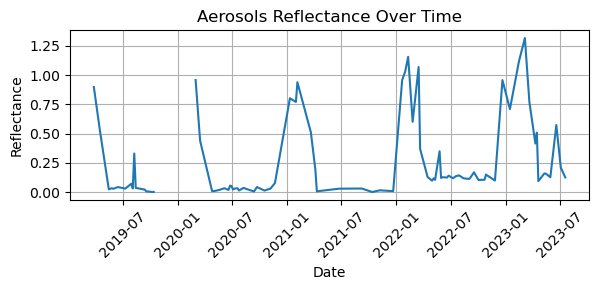

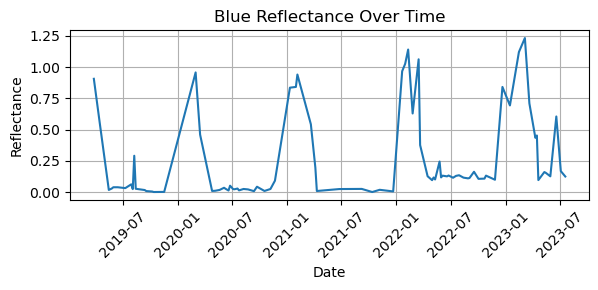

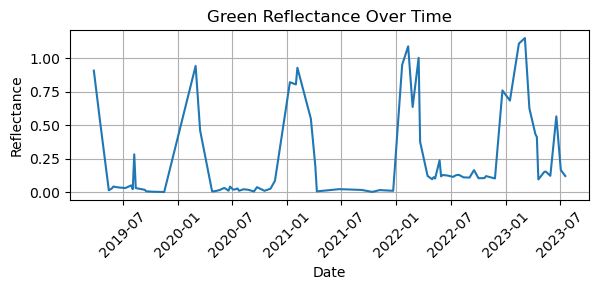

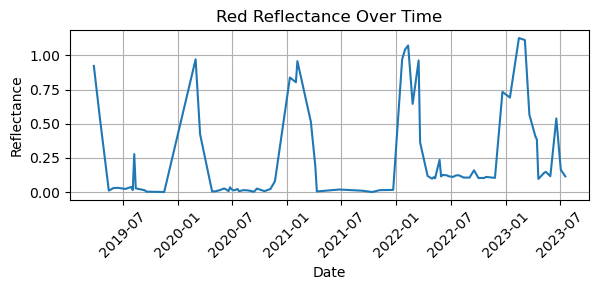

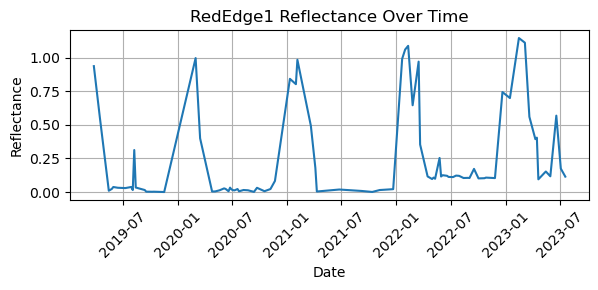

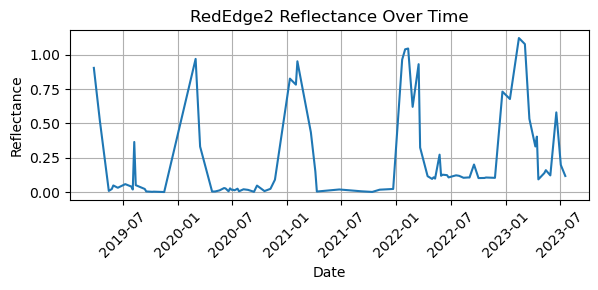

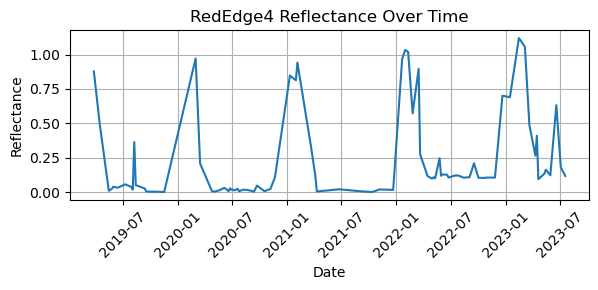

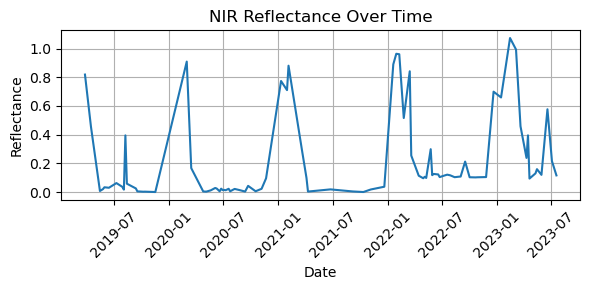

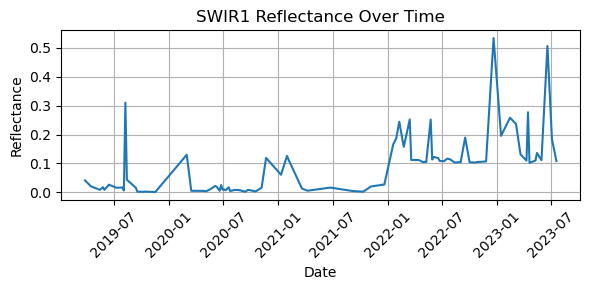

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Loop through each band and create a separate plot for each
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    plt.figure(figsize=(6, 3))  # Adjust the figsize to make the plot smaller
    plt.plot(df_band['Date'], df_band['Reflectance'])
    plt.xlabel('Date')
    plt.ylabel('Reflectance')
    plt.title(f'{band} Reflectance Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

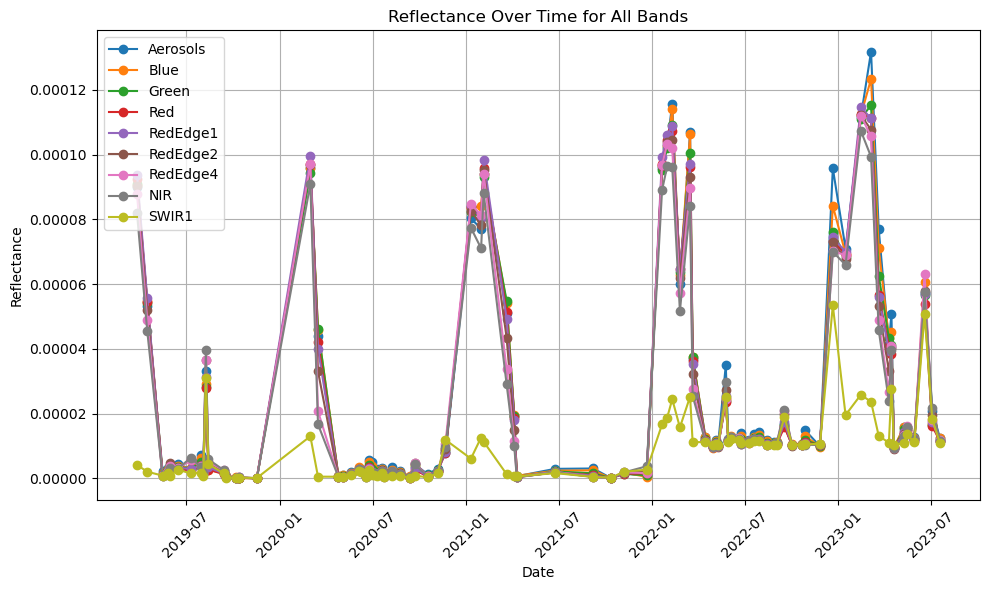

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

plt.figure(figsize=(10, 6))  # Adjust the figsize to make the plot larger
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], marker='o', label=band)

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time for All Bands')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

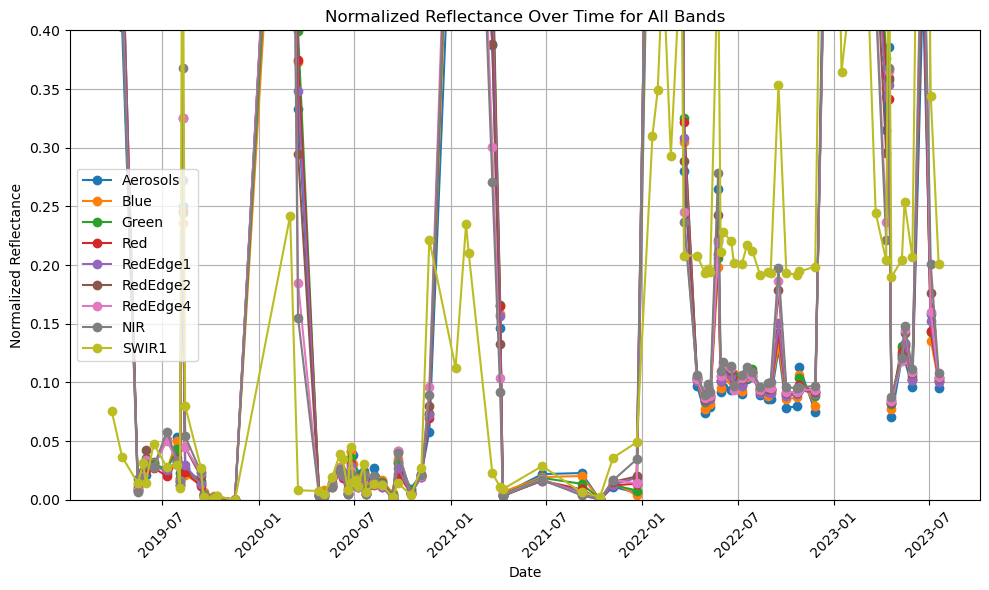

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 6))  # Adjust the figsize to make the plot larger
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, marker='o', label=band)

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time for All Bands')
plt.grid(True)
plt.ylim(0,0.4)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

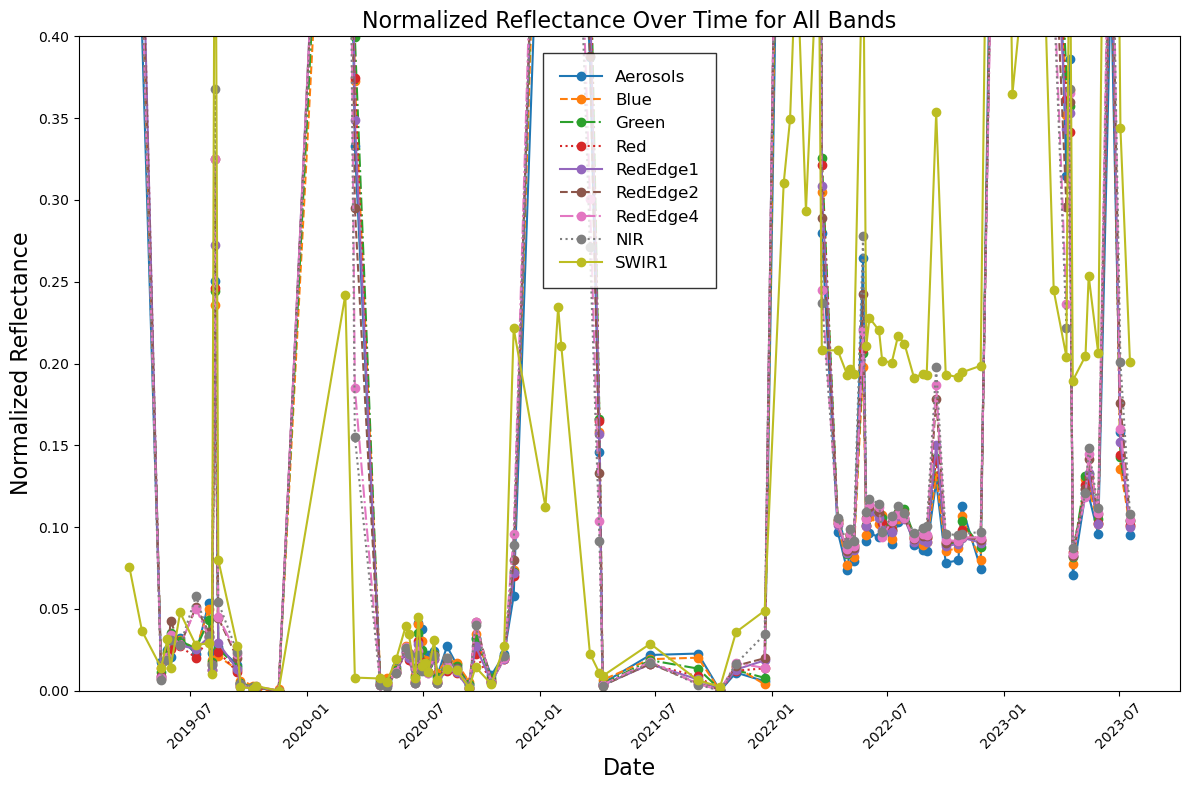

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(12, 8))  # Adjust the figsize to make the plot larger
line_styles = ['-', '--', '-.', ':']  # Different line styles for each band

for idx, band in enumerate(bands):
    df_band = df_data[df_data['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, marker='o', label=band, linestyle=line_styles[idx % len(line_styles)])

plt.xlabel('Date', fontsize=16)  # Increase text size for x-axis label
plt.ylabel('Normalized Reflectance', fontsize=16)  # Increase text size for y-axis label
plt.title('Normalized Reflectance Over Time for All Bands', fontsize=16)  # Increase text size for title
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(prop={'size': 12}, frameon=True, edgecolor='black', fancybox=False, borderpad=1, borderaxespad=1, handlelength=2.5)  # Make the border bold
plt.tight_layout()
plt.grid(False)  # Remove the grid
plt.show()

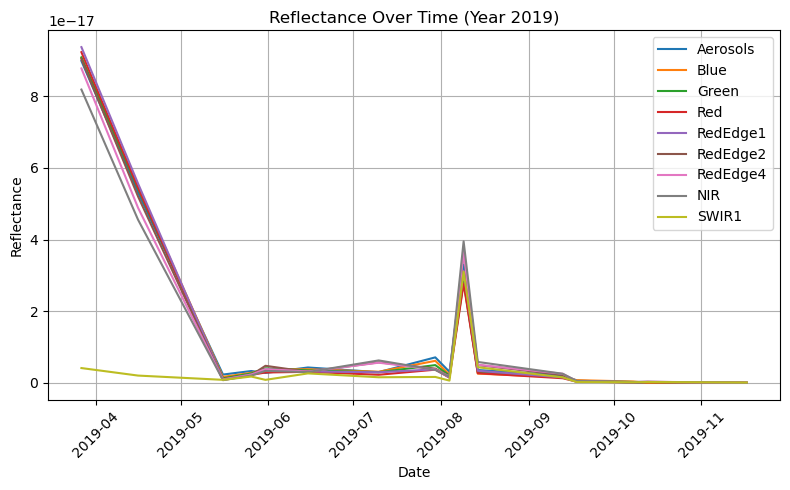

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Filter data for the year 2019
df_data_2019 = df_data[df_data['Date'].dt.year == 2019]

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed
for band in df_data_2019['Band'].unique():
    df_band = df_data_2019[df_data_2019['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], label=f'{band}')

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time (Year 2019)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

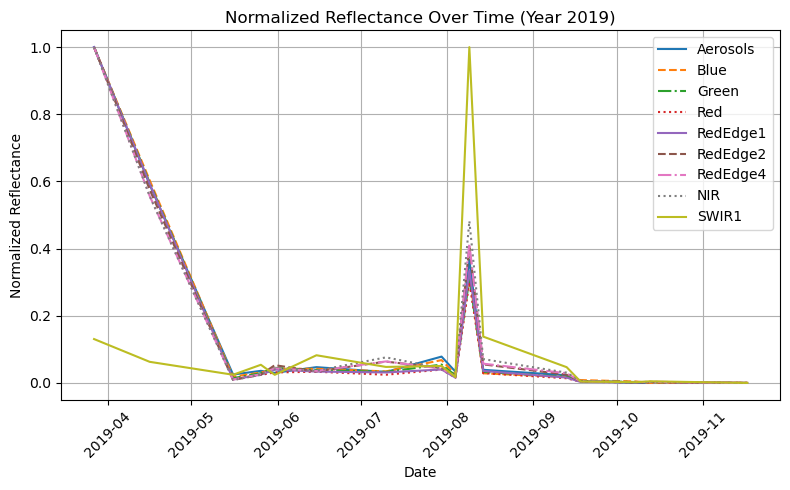

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Filter data for the year 2016
df_data_2019 = df_data[df_data['Date'].dt.year == 2019]

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed

# Define a list of different line styles for each band
line_styles = ['-', '--', '-.', ':']

# Get unique bands in the data
unique_bands = df_data_2019['Band'].unique()

# Plot each band with a different line style
for idx, band in enumerate(unique_bands):
    df_band = df_data_2019[df_data_2019['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, label=f'{band}', linestyle=line_styles[idx % len(line_styles)])

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time (Year 2019)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

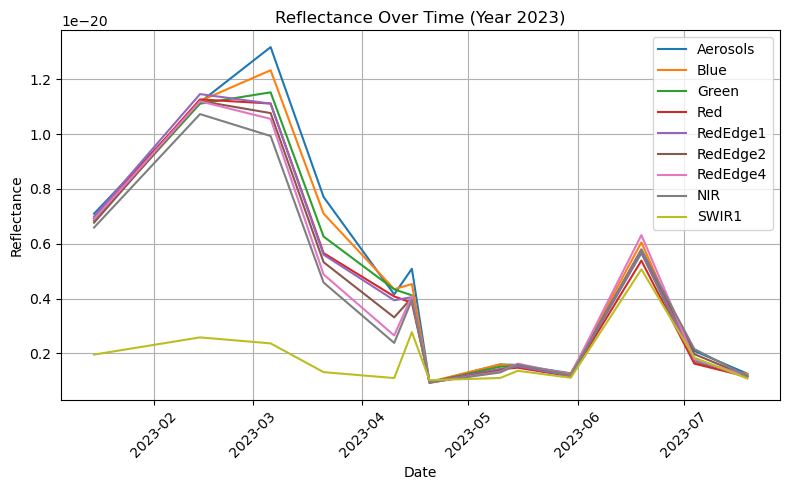

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Filter data for the year 2016
df_data_2023 = df_data[df_data['Date'].dt.year == 2023]

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed
for band in df_data_2023['Band'].unique():
    df_band = df_data_2023[df_data_2023['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], label=f'{band}')

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time (Year 2023)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

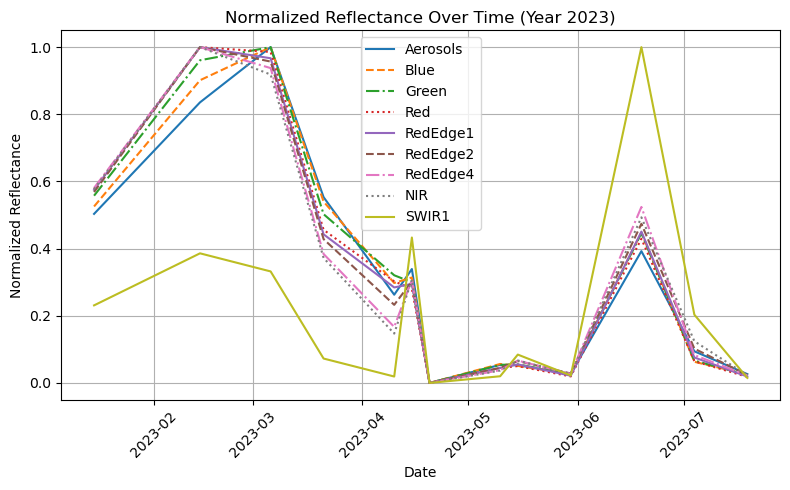

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Filter data for the year 2016
df_data_2023 = df_data[df_data['Date'].dt.year == 2023]

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed

# Define a list of different line styles for each band
line_styles = ['-', '--', '-.', ':']

# Get unique bands in the data
unique_bands = df_data_2023['Band'].unique()

# Plot each band with a different line style
for idx, band in enumerate(unique_bands):
    df_band = df_data_2023[df_data_2023['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, label=f'{band}', linestyle=line_styles[idx % len(line_styles)])

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time (Year 2023)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# DOC

In [41]:
import pandas as pd

# Read the "Site Information" Excel sheet to get the mapping between lake names and SITE_ID
site_info_df = pd.read_excel('Site_Information_2022_8_1 (2).xlsx')

# Search for the corresponding SITE_ID for the selected lake
site_id = site_info_df.loc[site_info_df['SITE_ID'] == selected_lake_id, 'SITE_NAME'].iloc[0]


In [42]:
import pandas as pd

# Read the data from the Excel file containing DOC values
data_doc = pd.read_excel('LTM_Data_2023_3_9.xlsx', usecols=['DOC_MG_L', 'PROGRAM_ID','SITE_ID', 'DATE_SMP'])

data_doc = data_doc[data_doc['DOC_MG_L'].notnull()]

# Sort the DataFrame by 'DATE_SMP' column in ascending order
data_doc = data_doc.sort_values(by='DATE_SMP')

# Filter data from 2019 onwards and based on the obtained SITE_ID
data = data_doc[(data_doc['DATE_SMP'] >= '2019-01-01') & (data_doc['SITE_ID'] == selected_lake_id)]

# Rename columns for readability
data = data.rename(columns={'DATE_SMP': 'Date', 'DOC_MG_L': 'DOC', 'SITE_ID': 'SITE_ID'})

# Print the DataFrame containing the DOC values for the selected lake
print(data)


       SITE_ID PROGRAM_ID       Date       DOC
18861  1A1-103   LTM_ALTM 2019-02-05  7.659300
38335  1A1-103   LTM_ALTM 2019-04-02  6.400300
37120  1A1-103   LTM_ALTM 2019-05-01  5.958300
16544  1A1-103   LTM_ALTM 2019-07-09  5.888300
1887   1A1-103   LTM_ALTM 2019-09-04  5.505700
38346  1A1-103   LTM_ALTM 2019-11-14  7.429081
37128  1A1-103   LTM_ALTM 2020-02-03  7.373080
5568   1A1-103   LTM_ALTM 2020-05-28  5.758763
32198  1A1-103   LTM_ALTM 2020-07-14  5.007855
16554  1A1-103   LTM_ALTM 2020-09-01  4.970554
3125   1A1-103   LTM_ALTM 2020-11-05  5.042800
28525  1A1-103   LTM_ALTM 2021-02-03  6.499600
34632  1A1-103   LTM_ALTM 2021-04-01  7.029300
1901   1A1-103   LTM_ALTM 2021-05-04  6.989800
8040   1A1-103   LTM_ALTM 2021-07-15  5.821500
11687  1A1-103   LTM_ALTM 2021-09-02  7.912200


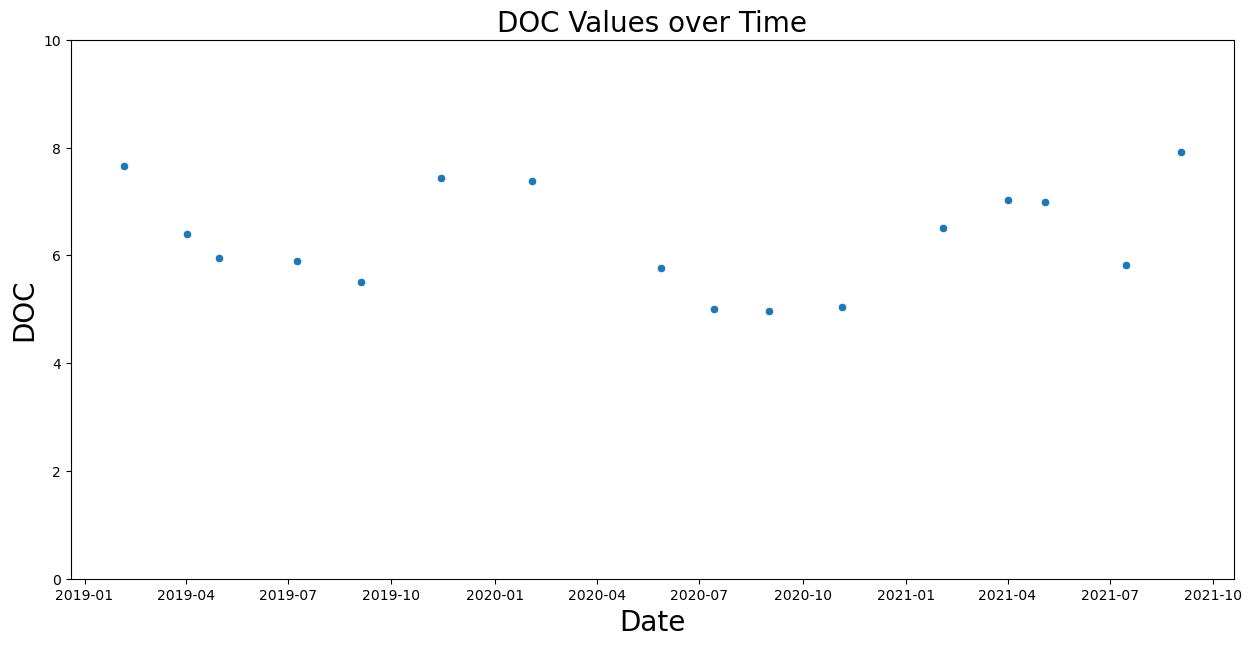

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=data, x='Date', y='DOC', ax=ax)

# Set the labels and title
ax.set_ylabel('DOC', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title('DOC Values over Time', fontsize=20)
ax.set_ylim(0, 10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))
#
# Display the plot
plt.show()


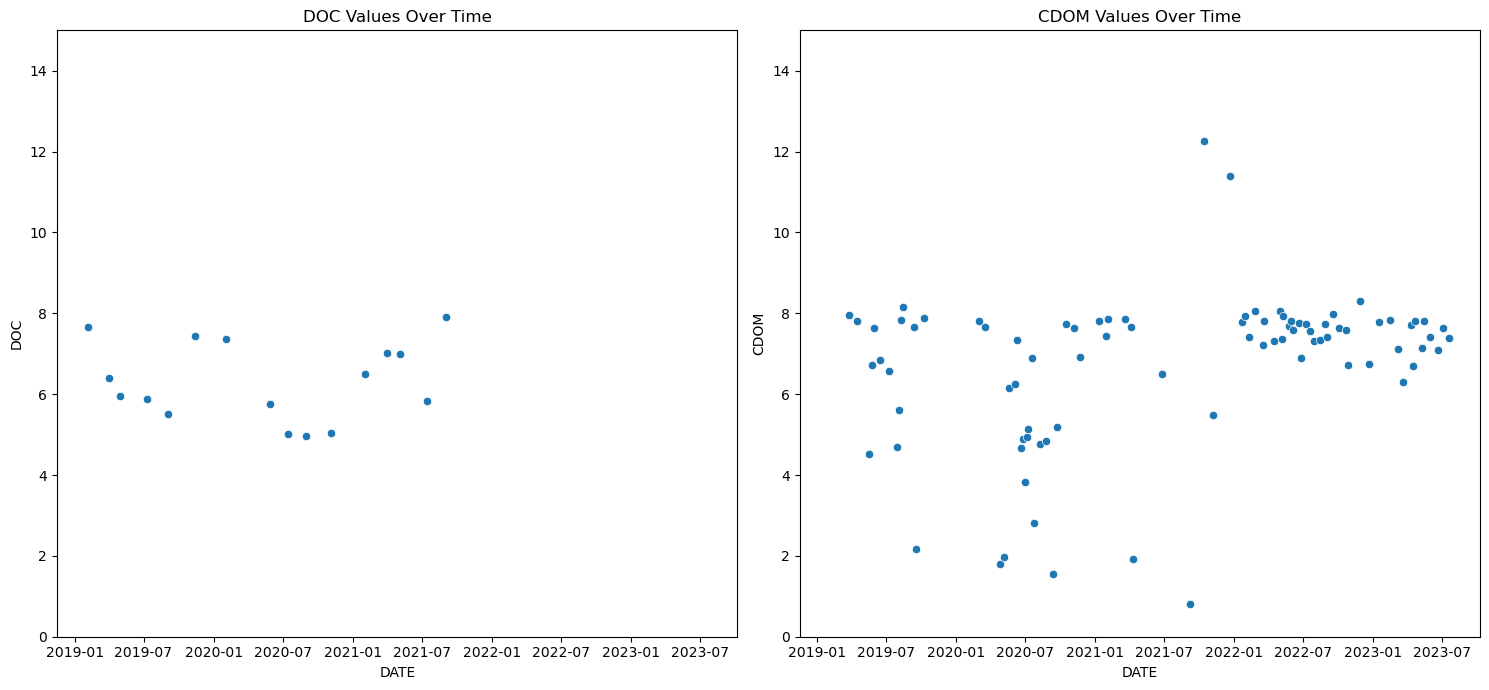

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# Seaborn scatter plot
sns.scatterplot(data=data, x='Date', y='DOC', ax=ax1)
ax1.set_xlabel('DATE')
ax1.set_ylabel('DOC')
ax1.set_ylim(0,15)

ax1.set_title('DOC Values Over Time')

# Seaborn scatter plot
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax2)
ax2.set_xlabel('DATE')
ax2.set_ylabel('CDOM')
ax2.set_ylim(0,15)
ax2.set_title('CDOM Values Over Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

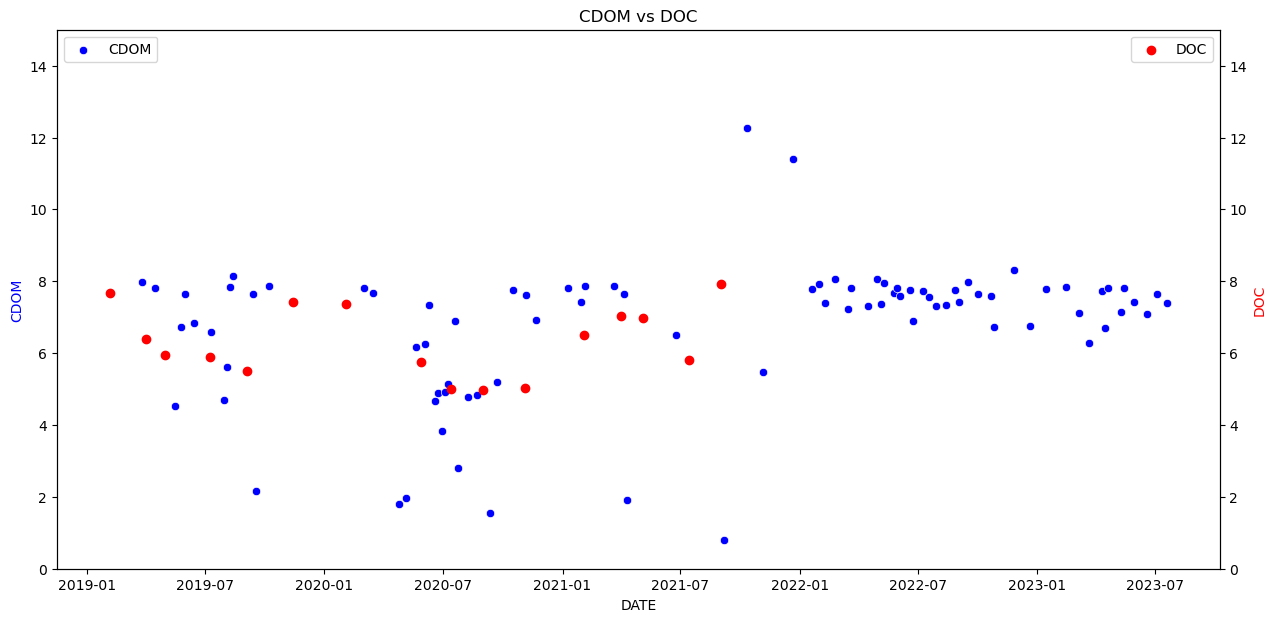

In [45]:
# CDOM vs DOC Timeseries
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(data['Date'], data['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(0,15)  # Adjust the range for CDOM
ax2.set_ylim(0, 15)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

In [46]:
import pandas as pd

# Sort the 'data' DataFrame by date in ascending order
data = data.sort_values(by='Date')

# Sort the 'df' DataFrame by the 'date' column in ascending order
df.sort_values('date', inplace=True)

# Convert the 'date' column in the 'df' DataFrame to datetime dtype
df['date'] = pd.to_datetime(df['date'])

# Perform an inner merge with a five-day window tolerance
merged_inner = pd.merge_asof(df, data, left_on='date', right_on='Date', tolerance=pd.Timedelta(days=5))

# Get rid of the null values resulting from the merge
merged_inner = merged_inner.dropna()

print(merged_inner)
#print(df.dtypes)
#print(data.dtypes)



         date         CDOM  SITE_ID PROGRAM_ID       Date       DOC
6  2019-07-10     6.579517  1A1-103   LTM_ALTM 2019-07-09  5.888300
15 2019-11-17  7021.686998  1A1-103   LTM_ALTM 2019-11-14  7.429081
28 2020-07-19     6.886747  1A1-103   LTM_ALTM 2020-07-14  5.007855
35 2020-11-06     7.629778  1A1-103   LTM_ALTM 2020-11-05  5.042800
39 2021-02-04     7.854804  1A1-103   LTM_ALTM 2021-02-03  6.499600
41 2021-04-05     7.653777  1A1-103   LTM_ALTM 2021-04-01  7.029300
44 2021-09-07     0.807573  1A1-103   LTM_ALTM 2021-09-02  7.912200


In [47]:
# Drop duplicate rows based on DOC column, keeping the first occurrence
merged_inner = merged_inner.drop_duplicates(subset=['DOC'])

# Print the updated DataFrame
#print(merged_inner)

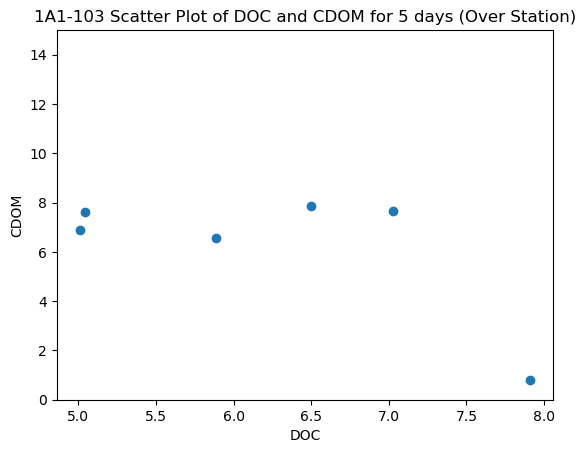

In [48]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(merged_inner['DOC'], merged_inner['CDOM'])
# Setting labels and title
plt.xlabel('DOC')
plt.ylabel('CDOM')
plt.title(selected_lake_id + ' ' + 'Scatter Plot of DOC and CDOM for 5 days (Over Station)')
plt.ylim(0,15)
# Displaying the plot
plt.show()

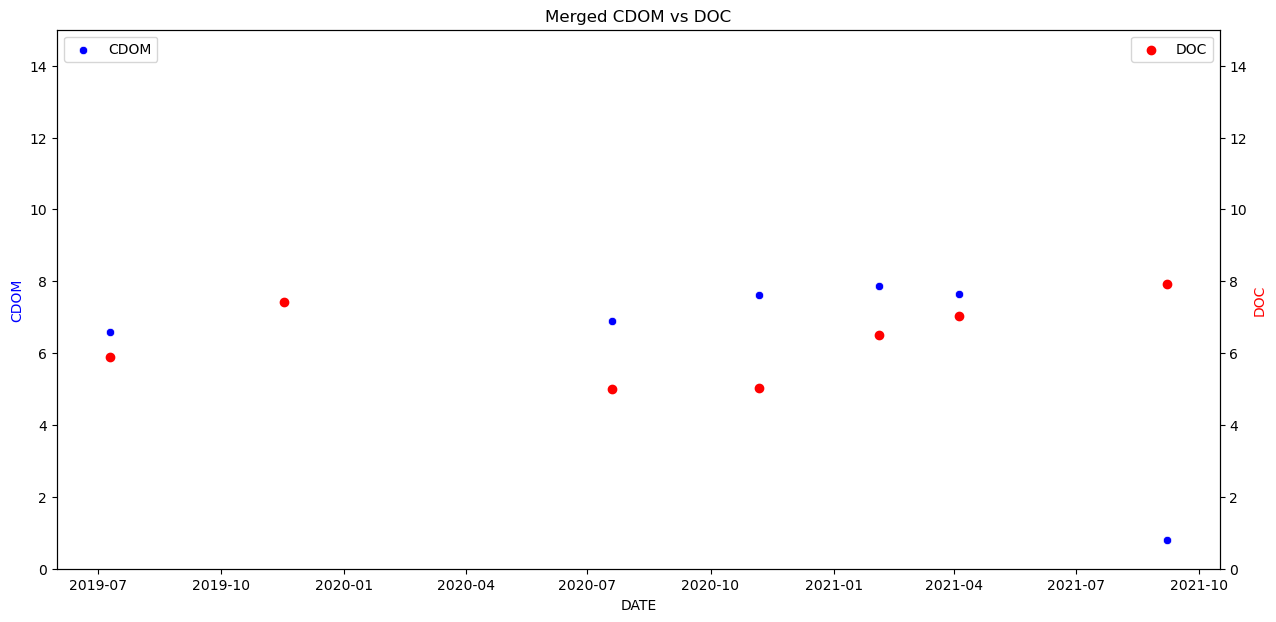

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=merged_inner, x='date', y='CDOM', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(merged_inner['date'], merged_inner['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('Merged CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(0, 15)  # Adjust the range for CDOM
ax2.set_ylim(0, 15)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

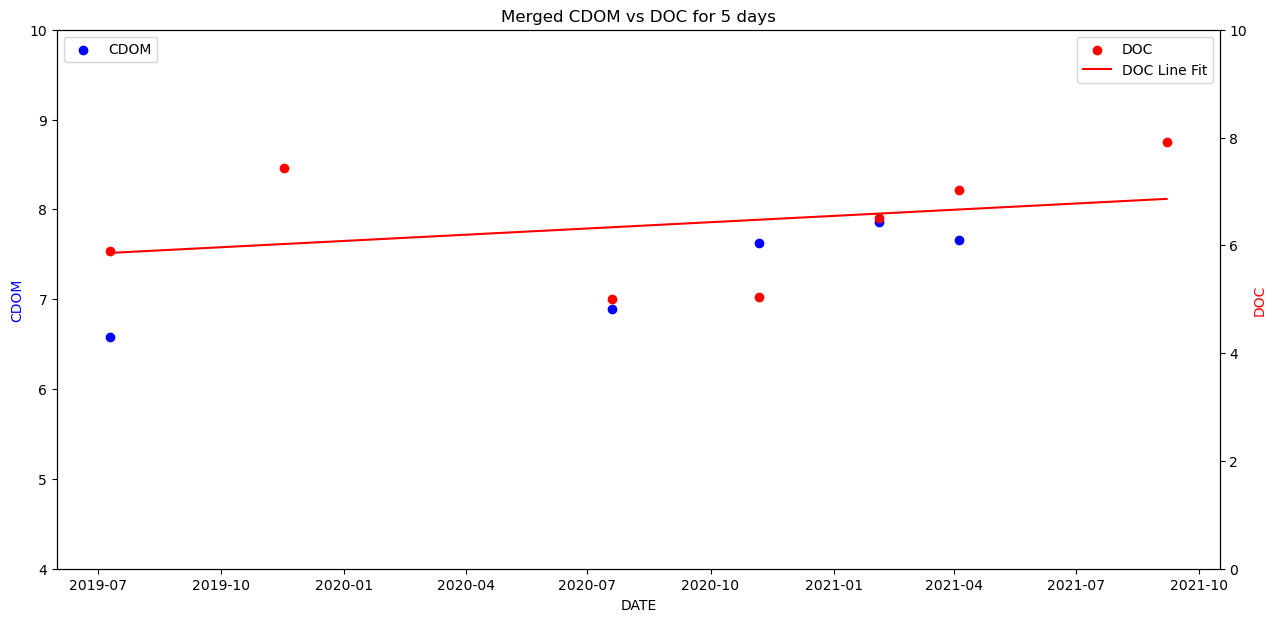

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert the date values to numeric format
merged_inner['date_numeric'] = pd.to_numeric(merged_inner['date']).astype(float)

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Matplotlib scatter plot 
ax.scatter(merged_inner['date'], merged_inner['CDOM'], label='CDOM', color='blue')


# Create a twin Axes object for DOC
ax2 = ax.twinx()
ax2.scatter(merged_inner['date'], merged_inner['DOC'], label='DOC', color='red')


# Calculate the linear regression line for CDOM
cdom_x = merged_inner['date_numeric']
cdom_y = merged_inner['CDOM']
cdom_slope, cdom_intercept = np.polyfit(cdom_x, cdom_y, 1)
cdom_line = cdom_slope * cdom_x + cdom_intercept
#ax.plot(merged_inner['date'], cdom_line, color='blue', label='CDOM Line Fit')

# Calculate the linear regression line for DOC
doc_x = merged_inner['date_numeric']
doc_y = merged_inner['DOC']
doc_slope, doc_intercept = np.polyfit(doc_x, doc_y, 1)
doc_line = doc_slope * doc_x + doc_intercept
ax2.plot(merged_inner['date'], doc_line, color='red', label='DOC Line Fit')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('Merged CDOM vs DOC for 5 days')

# Set different ranges for the y-axes
ax.set_ylim(4, 10)  # Adjust the range for CDOM
ax2.set_ylim(0, 10)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

In [51]:
def station_mean(img, lake_polygon):
    # Mean of a specific band (CO) within a region
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake_polygon, scale=20).get('CO')
    return img.set('date', img.date().format()).set('CDOM', mean)

# Create an empty DataFrame to store CDOM values for all lakes
all_lakes_cdom = pd.DataFrame()

# Get CDOM values for all lakes
for lake_id in target_lake_ids:
    # Check if the lake ID exists in the DataFrame
    if lake_id in df_lake_info['SITE_ID'].values:
        # Get the information for the current lake
        lake_info = df_lake_info[df_lake_info['SITE_ID'] == lake_id].iloc[0]
        lat = lake_info['LATDD_CENT']
        lon = lake_info['LONDD_CENT']

        # Create a polygon around the current lake using the latitude and longitude
        lake_polygon = create_lake_polygon(lat, lon)

        # Load the lake-specific feature collection
        lake_collection = ee.FeatureCollection('projects/ee-mazarderakhsh/assets/lake_polygons') \
            .filter(ee.Filter.eq('GNIS_Name', lake_info['SITE_NAME']))

        # Apply the processing steps for the current lake
        s2_lake = s2.filterBounds(lake_polygon) \
                   .map(lambda img: cdom(img, lake_polygon)) \
                   .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 25))

        # Map the station_mean function over the lake images
        station_reduced_imgs = s2_lake.map(lambda img: station_mean(img, lake_polygon))

        # Reduce the image collection to a nested list of dates and CDOM values
        nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date', 'CDOM']).get('list')

        # Convert the nested list to a DataFrame
        lake_cdom_df = pd.DataFrame(nested_list.getInfo(), columns=['date', 'CDOM'])

        # Add 'SITE_ID' and 'SITE_NAME' columns to the DataFrame
        lake_cdom_df['SITE_ID'] = lake_id
        lake_cdom_df['SITE_NAME'] = lake_info['SITE_NAME']

        # Append the DataFrame for the current lake to the overall DataFrame
        all_lakes_cdom = all_lakes_cdom.append(lake_cdom_df)

# Reset the DataFrame index
all_lakes_cdom.reset_index(drop=True, inplace=True)
# Convert the 'date' column to datetime format
all_lakes_cdom['date'] = pd.to_datetime(all_lakes_cdom['date'])

# Format 'date' column to exclude the time
all_lakes_cdom['date'] = all_lakes_cdom['date'].dt.date

# Print the DataFrame with CDOM values for all lakes
pd.set_option('display.max_rows', None)
print(all_lakes_cdom)

            date          CDOM  SITE_ID                 SITE_NAME
0     2019-03-27      7.738038   020058          Little Hope Pond
1     2019-05-31      8.111728   020058          Little Hope Pond
2     2019-07-10      6.435688   020058          Little Hope Pond
3     2019-07-15      8.083588   020058          Little Hope Pond
4     2019-07-20      8.240006   020058          Little Hope Pond
5     2019-08-04      7.902216   020058          Little Hope Pond
6     2019-08-14      6.585209   020058          Little Hope Pond
7     2019-09-13     12.780202   020058          Little Hope Pond
8     2019-09-18      5.454759   020058          Little Hope Pond
9     2019-10-08   1334.791383   020058          Little Hope Pond
10    2019-10-13     13.473879   020058          Little Hope Pond
11    2019-11-17      7.866868   020058          Little Hope Pond
12    2020-02-05      7.695035   020058          Little Hope Pond
13    2020-03-21      7.849027   020058          Little Hope Pond
14    2020

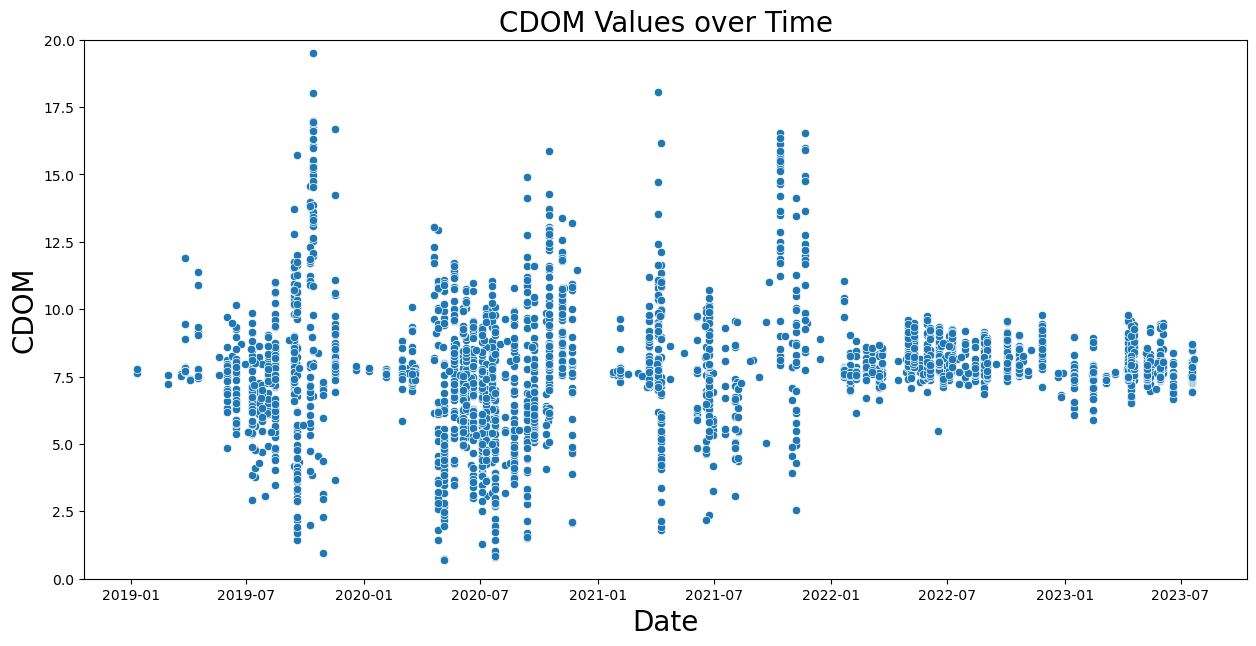

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

# Convert the 'date' column to datetime format
all_lakes_cdom['date'] = pd.to_datetime(all_lakes_cdom['date'])

# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our DataFrame to the data argument
sns.scatterplot(data=all_lakes_cdom, x='date', y='CDOM', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title('CDOM Values over Time', fontsize=20)
ax.set_ylim(0, 20)

# Format the x-axis tick labels to display only the year
#ax.xaxis.set_major_formatter(plt.FixedFormatter(all_lakes_cdom['date'].dt.year.unique()))

# Rotate the x-axis tick labels for better readability
#plt.xticks(rotation=45)

# Display the plot
plt.show()


Reflectance Values

In [53]:
import pandas as pd

# Function to calculate the mean of specific bands indicated by STD_NAMES for a given lake polygon
def reflectance(img, lake):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).select(STD_NAMES)
    return ee.Feature(None, {'date': img.date().format(), 'reflectance': reflectance_values})

# Create an empty DataFrame to store reflectance values for all lakes
all_lakes_reflectance = pd.DataFrame()

# Get reflectance values for all lakes
for lake_id in target_lake_ids:
    # Check if the lake ID exists in the DataFrame
    if lake_id in df_lake_info['SITE_ID'].values:
        # Get the information for the current lake
        lake_info = df_lake_info[df_lake_info['SITE_ID'] == lake_id].iloc[0]
        lat = lake_info['LATDD_CENT']
        lon = lake_info['LONDD_CENT']

        # Create a polygon around the current lake using the latitude and longitude
        lake_polygon = create_lake_polygon(lat, lon)

        # Calculate the reflectance values for all dates for the current lake
        s2_reflectance = s2.filterBounds(lake_polygon).map(lambda img: reflectance(img, lake_polygon))

        # Convert the image collection to a list and get the data for the DataFrame
        s2_list = s2_reflectance.reduceColumns(ee.Reducer.toList(2), ['date', 'reflectance']).values().get(0)
        df_s2_reflectance = pd.DataFrame(s2_list.getInfo(), columns=['date', 'reflectance'])

        # Convert date column to datetime and extract date only
        df_s2_reflectance['date'] = pd.to_datetime(df_s2_reflectance['date']).dt.date

        # Set the reflectance column values to a dictionary
        df_s2_reflectance['reflectance'] = df_s2_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})

        # Add 'SITE_ID' and 'SITE_NAME' columns to the DataFrame
        df_s2_reflectance['SITE_ID'] = lake_id
        df_s2_reflectance['SITE_NAME'] = lake_info['SITE_NAME']

        # Append the DataFrame for the current lake to the overall DataFrame
        all_lakes_reflectance = all_lakes_reflectance.append(df_s2_reflectance)

# Reset the DataFrame index
all_lakes_reflectance.reset_index(drop=True, inplace=True)

# Print the DataFrame with reflectance values for all lakes
pd.set_option('display.max_rows', None)
print(all_lakes_reflectance)


             date                                        reflectance  SITE_ID  \
0      2019-01-01                                                 {}   020058   
1      2019-01-06  {'Aerosols': 3361.006241331485, 'Blue': 3072.6...   020058   
2      2019-01-11                                                 {}   020058   
3      2019-01-16                                                 {}   020058   
4      2019-01-21                                                 {}   020058   
5      2019-01-26                                                 {}   020058   
6      2019-01-31                                                 {}   020058   
7      2019-02-05                                                 {}   020058   
8      2019-02-10                                                 {}   020058   
9      2019-02-15                                                 {}   020058   
10     2019-02-20                                                 {}   020058   
11     2019-02-25           

In [54]:
# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in all_lakes_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a DataFrame from the data
df_data = pd.DataFrame(data)

# Display the DataFrame with limited rows to avoid crashing the notebook
pd.set_option('display.max_rows', 20)  # Change the value as needed
print(df_data)


           Band  Reflectance        Date
0      Aerosols  3361.006241  2019-01-06
1          Blue  3072.679612  2019-01-06
2         Green  2780.961165  2019-01-06
3           Red  2532.472954  2019-01-06
4      RedEdge1  2581.873786  2019-01-06
...         ...          ...         ...
98500  RedEdge1  9551.672703  2023-08-03
98501  RedEdge2  8833.636486  2023-08-03
98502  RedEdge4  8831.446009  2023-08-03
98503       NIR  8240.509054  2023-08-03
98504     SWIR1  4861.015426  2023-08-03

[98505 rows x 3 columns]


In [55]:
# Average band reflectance values for each month
data_by_month = {}

# Extract the bands, reflectance values, and dates where available
for index, row in all_lakes_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'reflectance_values': {band: [] for band in STD_NAMES}}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['reflectance_values'][band].append(value)

# Calculate the average reflectance values for each band within each month
average_data = {'band': [], 'average_reflectance': []}

for month, data in data_by_month.items():
    for band, reflectance_values in data['reflectance_values'].items():
        if reflectance_values:  # Check if reflectance_values is not empty
            average_value = sum(reflectance_values) / len(reflectance_values)
            average_data['band'].append(band)
            average_data['average_reflectance'].append(average_value)

# Create a DataFrame from the average data
df_average_data = pd.DataFrame(average_data)

# Display the DataFrame
print(df_average_data)

         band  average_reflectance
0    Aerosols             0.603928
1        Blue             0.646616
2       Green             0.618441
3         Red             0.612037
4    RedEdge1             0.617643
..        ...                  ...
103  RedEdge1             0.584117
104  RedEdge2             0.579868
105  RedEdge4             0.583491
106       NIR             0.551626
107     SWIR1             0.120145

[108 rows x 2 columns]


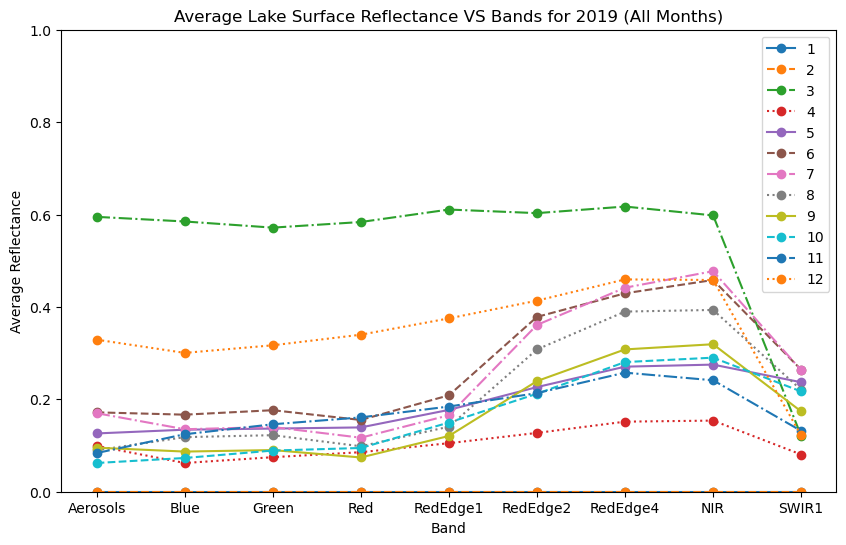

In [56]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['dates'].append(date)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in data_by_month.items():
    unique_dates = list(set(data['dates']))  # Get unique dates for the month
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    
    average_reflectance_values = []
    for band in STD_NAMES:
        reflectance_values = [data['reflectance'][i] for i in range(len(data['band'])) if data['band'][i] == band]
        
        if len(reflectance_values) > 0:
            average_reflectance = sum(reflectance_values) / len(reflectance_values)
            average_reflectance_values.append(average_reflectance)
        else:
            average_reflectance_values.append(0)
    
    plt.plot(STD_NAMES, average_reflectance_values, linestyle=line_style, marker='o', label=month)
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 1)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for 2019 (All Months)')
plt.legend()
plt.show()


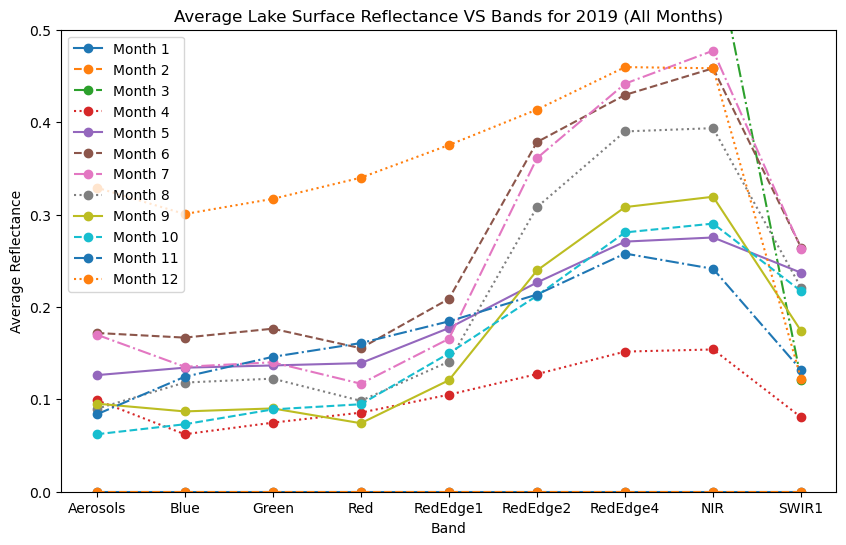

In [57]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['dates'].append(date)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in data_by_month.items():
    unique_dates = list(set(data['dates']))  # Get unique dates for the month
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    
    average_reflectance_values = []
    for band in STD_NAMES:
        reflectance_values = [data['reflectance'][i] for i in range(len(data['band'])) if data['band'][i] == band]
        
        if len(reflectance_values) > 0:
            average_reflectance = sum(reflectance_values) / len(reflectance_values)
            average_reflectance_values.append(average_reflectance)
        else:
            average_reflectance_values.append(0)
    
    plt.plot(STD_NAMES, average_reflectance_values, linestyle=line_style, marker='o', label=f"Month {month}")
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 0.5)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for 2019 (All Months)')
plt.legend()
plt.show()


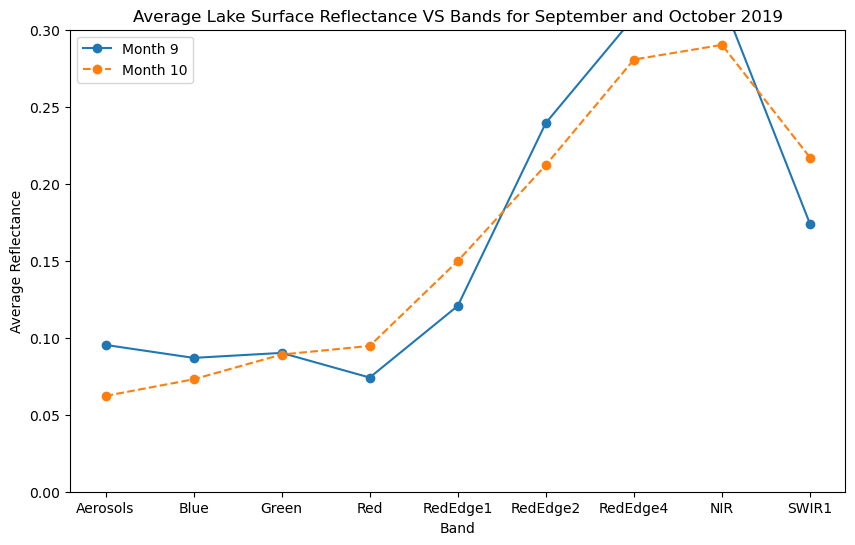

In [58]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    month = date.month
    
    if year == 2019 and month in [9, 10]:  # Filter for September (9) and October (10) only
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--']  # List of line styles for two months
style_index = 0

for month, data in data_by_month.items():
    band_averages = {band: sum(data['reflectance'][i] for i, b in enumerate(data['band']) if b == band) / data['band'].count(band) for band in STD_NAMES}
    bands = list(band_averages.keys())
    reflectance_values = list(band_averages.values())
    
    line_style = line_styles[style_index]  # Cycle through line styles
    
    plt.plot(bands, reflectance_values, linestyle=line_style, marker='o', label=f'Month {month}')
    
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 0.3)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for September and October 2019')
plt.legend()
plt.show()


In [59]:
import pandas as pd

# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)


          Band  Reflectance        Date
0     Aerosols  5949.465819  2019-03-22
1         Blue  5849.436407  2019-03-22
2        Green  5716.272655  2019-03-22
3          Red  5837.840223  2019-03-22
4     RedEdge1  6107.714626  2019-03-22
...        ...          ...         ...
3271  RedEdge1  9551.672703  2023-08-03
3272  RedEdge2  8833.636486  2023-08-03
3273  RedEdge4  8831.446009  2023-08-03
3274       NIR  8240.509054  2023-08-03
3275     SWIR1  4861.015426  2023-08-03

[3276 rows x 3 columns]


In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data_by_month['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data_by_month['Band'].unique()

# Loop through each band and create a separate plot for each
for band in bands:
    df_band = df_data_by_month[df_data_by_month['Band'] == band]
    plt.figure(figsize=(10, 6))  # Adjust the figsize to make the plot larger
    plt.plot(df_band['Date'], df_band['Reflectance'])
    plt.xlabel('Date')
    plt.ylabel('Reflectance')
    plt.title(f'{band} Reflectance Over Time for All Lakes')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


NameError: name 'df_data_by_month' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Create a figure to display all bands in one graph
plt.figure(figsize=(10, 6))

# Loop through each band and plot the combined reflectance values
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], label=band)

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time for All Lakes')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='Band')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

plt.figure(figsize=(10, 6))  # Adjust the figsize to make the plot larger
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], marker='o', label=band)

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time for All Bands')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 6))  # Adjust the figsize to make the plot larger

# Create a separate line plot for each band
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, label=band)

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time for All Bands')
plt.grid(True)
plt.ylim(0, 1)  # Adjust the y-axis limit for better visualization
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 6))  # Adjust the figsize to make the plot larger

# Create an empty dictionary to store normalized reflectance for each band
normalized_data_by_band = {band: [] for band in bands}

# Loop through each band and calculate normalized reflectance for all lakes
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    normalized_data_by_band[band] = normalized_reflectance.tolist()

# Plot the normalized reflectance for each band for all lakes
for band in bands:
    plt.plot(df_data[df_data['Band'] == band]['Date'], normalized_data_by_band[band], marker='o', label=band)

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time for All Bands and All Lakes')
plt.grid(True)
plt.ylim(0, 1)  # Adjust the y-axis limit for better visualization
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Filter data for the year 2019
df_data_2019 = df_data[df_data['Date'].dt.year == 2019]

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed
for band in df_data_2019['Band'].unique():
    df_band = df_data_2019[df_data_2019['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], label=f'{band}')

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time (Year 2019)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Filter data for the year 2016
df_data_2019 = df_data[df_data['Date'].dt.year == 2019]

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed

# Define a list of different line styles for each band
line_styles = ['-', '--', '-.', ':']

# Get unique bands in the data
unique_bands = df_data_2019['Band'].unique()

# Plot each band with a different line style
for idx, band in enumerate(unique_bands):
    df_band = df_data_2019[df_data_2019['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, label=f'{band}', linestyle=line_styles[idx % len(line_styles)])

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time (Year 2019)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Filter data for the year 2016
df_data_2023 = df_data[df_data['Date'].dt.year == 2023]

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed
for band in df_data_2023['Band'].unique():
    df_band = df_data_2023[df_data_2023['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], label=f'{band}')

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time (Year 2023)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Filter data for the year 2016
df_data_2023 = df_data[df_data['Date'].dt.year == 2023]

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed

# Define a list of different line styles for each band
line_styles = ['-', '--', '-.', ':']

# Get unique bands in the data
unique_bands = df_data_2023['Band'].unique()

# Plot each band with a different line style
for idx, band in enumerate(unique_bands):
    df_band = df_data_2023[df_data_2023['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, label=f'{band}', linestyle=line_styles[idx % len(line_styles)])

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time (Year 2023)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

DOC for all Lakes

In [ ]:
import pandas as pd

# Read the "Site Information" Excel sheet to get the mapping between lake names and SITE_ID
site_info_df = pd.read_excel('/Users/mindsmatter/Desktop/Lakes/Site_Information_2022_8_1 (2).xlsx')

# Read the data from the Excel file containing DOC values
data_doc = pd.read_excel('/Users/mindsmatter/Desktop/Lakes/LTM_Data_2023_3_9.xlsx', usecols=['DOC_MG_L', 'SITE_ID', 'DATE_SMP'])

data_doc = data_doc[data_doc['DOC_MG_L'].notnull()]

# Sort the DataFrame by 'DATE_SMP' column in ascending order
data_doc = data_doc.sort_values(by='DATE_SMP')

In [ ]:
import pandas as pd

# Create an empty DataFrame to store the results
all_lakes_doc_data = pd.DataFrame()

# Loop through each lake ID in the 'SITE_ID' column
for site_id in target_lake_ids:
    # Filter data for the current lake based on the obtained SITE_ID
    data = data_doc[data_doc['SITE_ID'] == site_id]
    # Rename columns for readability
    data = data.rename(columns={'DATE_SMP': 'Date', 'DOC_MG_L': 'DOC', 'SITE_ID': 'SITE_ID'})
    # Append the data for the current lake to the overall DataFrame
    all_lakes_doc_data = all_lakes_doc_data.append(data)

# Convert 'Date' column to pandas datetime type
all_lakes_doc_data['Date'] = pd.to_datetime(all_lakes_doc_data['Date'])

# Print the DataFrame containing the DOC values for all lakes
print(all_lakes_doc_data)



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

# Create an empty DataFrame to store the results
all_lakes_doc_data = pd.DataFrame()

# Loop through each lake ID in the 'SITE_ID' column
for site_id in data_doc['SITE_ID'].unique():
    # Filter data for the current lake based on the obtained SITE_ID
    data = data_doc[data_doc['SITE_ID'] == site_id]
    # Rename columns for readability
    data = data.rename(columns={'DATE_SMP': 'Date', 'DOC_MG_L': 'DOC', 'SITE_ID': 'SITE_ID'})
    # Append the data for the current lake to the overall DataFrame
    all_lakes_doc_data = all_lakes_doc_data.append(data)

# Convert 'Date' column to pandas datetime type
all_lakes_doc_data['Date'] = pd.to_datetime(all_lakes_doc_data['Date'])

# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our DataFrame to the data argument
sns.scatterplot(data=all_lakes_doc_data, x='Date', y='DOC', ax=ax)

# Set the labels and title
ax.set_ylabel('DOC', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title('DOC Values over Time for All Lakes', fontsize=20)
ax.set_ylim(0, 25)

# Format the x-axis tick labels to display only the year
#ax.xaxis.set_major_formatter(plt.FixedFormatter(all_lakes_doc_data['Date'].dt.year.unique()))

# Display the plot
plt.show()



In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt

## Convert 'Date' column to pandas datetime type
#df_data['Date'] = pd.to_datetime(df_data['Date'])

## Create a figure with two subplots side by side
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

## Seaborn scatter plot for DOC data
#sns.scatterplot(data=df_data, x='Date', y='DOC', ax=ax1)
#ax1.set_xlabel('Date')
#ax1.set_ylabel('DOC')
#ax1.set_ylim(0, 15)
#ax1.set_title('DOC Values Over Time')

## Seaborn scatter plot for CDOM data
#sns.scatterplot(data=all_lakes_cdom, x='date', y='CDOM', ax=ax2)
#ax2.set_xlabel('Date')
#ax2.set_ylabel('CDOM')
#ax2.set_ylim(0, 15)
#ax2.set_title('CDOM Values Over Time')

## Adjust the spacing between subplots
#plt.tight_layout()

## Display the plot
#plt.show()


In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt

## Create a figure and an Axes object
#fig, ax = plt.subplots(figsize=(15, 7))

## Seaborn scatter plot for CDOM
#sns.scatterplot(data=all_lakes_doc_data, x='Date', y='CDOM', ax=ax, label='CDOM', color='blue')

## Create a twin Axes object for DOC
#ax2 = ax.twinx()

## Matplotlib scatter plot for DOC
#ax2.scatter(all_lakes_doc_data['Date'], all_lakes_doc_data['DOC'], label='DOC', color='red')

## Set the labels and title
#ax.set_xlabel('DATE')
#ax.set_ylabel('CDOM', color='blue')
#ax2.set_ylabel('DOC', color='red')
#ax.set_title('CDOM vs DOC Timeseries for All Lakes')

## Set different ranges for the y-axes
#ax.set_ylim(0, 15)  # Adjust the range for CDOM
#ax2.set_ylim(0, 15)  # Adjust the range for DOC

## Add legends
#ax.legend(loc='upper left')
#ax2.legend(loc='upper right')

## Display the plot
#plt.show()


In [ ]:
import pandas as pd

# Sort the 'all_lakes_doc_data' DataFrame by 'Date' column in ascending order
all_lakes_doc_data = all_lakes_doc_data.sort_values(by='Date')

# Sort the 'all_lakes_cdom' DataFrame by the 'date' column in ascending order
all_lakes_cdom.sort_values('date', inplace=True)

# Convert the 'Date' column in the 'all_lakes_doc_data' DataFrame to datetime dtype
all_lakes_doc_data['Date'] = pd.to_datetime(all_lakes_doc_data['Date'])

# Convert the 'date' column in the 'all_lakes_cdom' DataFrame to datetime dtype
all_lakes_cdom['date'] = pd.to_datetime(all_lakes_cdom['date'])

# Perform an inner merge with a five-day window tolerance on 'DOC' and 'CDOM' data
merged_inner = pd.merge_asof(all_lakes_doc_data, all_lakes_cdom[['date', 'CDOM']], left_on='Date', right_on='date', tolerance=pd.Timedelta(days=5))

# Drop the redundant 'date' column from the merged DataFrame
merged_inner = merged_inner.drop(columns=['date'])

# Get rid of the null values resulting from the merge
merged_inner = merged_inner.dropna()

# Reset the DataFrame index
merged_inner.reset_index(drop=True, inplace=True)

# Convert the 'Date' column to datetime format
merged_inner['Date'] = pd.to_datetime(merged_inner['Date'])

# Format 'Date' column to exclude the time
merged_inner['Date'] = merged_inner['Date'].dt.date

# Print the DataFrame with merged DOC and CDOM values for all lakes
pd.set_option('display.max_rows', None)
print(merged_inner)



In [ ]:
# Drop duplicate rows based on DOC column, keeping the first occurrence
merged_inner = merged_inner.drop_duplicates(subset=['DOC'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the 'SITE_NAME' column from the 'all_lakes_cdom' DataFrame into the merged DataFrame based on the 'SITE_ID' column
merged_inner = pd.merge(merged_inner, all_lakes_cdom[['SITE_ID', 'SITE_NAME']], on='SITE_ID', how='inner')

# Create a scatter plot with Seaborn, using 'SITE_NAME' as the hue
sns.scatterplot(data=merged_inner, x='DOC', y='CDOM', hue='SITE_NAME', palette='tab10')

# Setting labels and title
plt.xlabel('DOC')
plt.ylabel('CDOM')
plt.title('Scatter Plot of DOC and CDOM for 5 days (All Lakes)')
plt.ylim(0, 15)

# Displaying the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.show()
